# 

# Closed-Loop Simulation with SHARPy as a hardware-in-the-loop system

This tutorial examplifies the application of an arbitary controller on a nonlinear aeroelastic problem using SHARPy as a hardware-in-the-loop system. This controller receives sensor measurements from SHARPy using an interface based on the User Datagram Protocol (UDP). After generating the control input, the control interface feeds this input back to the actuators incorporated in SHARPy again through the UDP-interface.  

PICTURE 

The objective of this notebook is to give the reader all methods necessary to use SHARPy's capablities of applying controller on nonlinear aeroservoelastic problems by themself, including generating a linear reduced-order model (ROM) of the nonlinear model for the control design and finally, how to apply their controller on a nonlinear aeroelastic simulation using SHARPy.

Reading material recommended are:
1.  Marc Artola
2. Stefanie Duessler
3. Norberto Pazy

Please note that this notebook requires ?? hours to be completed. 

The notebook is structured such that first, we design the model and its operational point. Second, the model is linearized and reduced. The resulting reduced-order model (ROM) can then be used for an efficient control design. Third, we apply via an UDP-Interface the designed controller on a nonlinear aeroelastic simulation performed with SHARPy.



## Requirements

This notebook needs to be run wit

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sharpy.cases.templates.flying_wings as wings
import sharpy.sharpy_main
import json

## Demonstrator Model 

The very-flexible Pazy wing serves as demonstrator model and an aileron located near the wingtip as an actuator.

INSERT PICTURE OF PAZY

The control objective in this example is to alleviate the wingtip displacement due to gust-induced wing loads. As an example, we use a P-controller implemented in a Python interface with the objective to reduce the wingtip displacement induced by a gust encounter. However, the reader can test any controller run on any platform as long as a working UDP connection to SHARPy can be established. 



### Flight Operation Point

In [2]:
u_inf = 40 # m/s
alpha_deg = 1
rho = 1.225

### Wing and Wake Lattice Discretisation

In [3]:
number_chordwise_panels = 4
number_spanwise_nodes = 16
wake_length_factor = 10

num_control_surfaces = 2;

### General Simulation Settings

In [4]:
num_cores = 2
simulation_time = 1.0

In [5]:
cases_folder = './cases/' # folder to store input files 
output_folder = './output' # folder to save results
route_notebook_dir =  os.path.abspath('')

## Open-Loop Gust Response
After, defining the general model settings, we now simulate the open-loop response of the Pazy wing to a gust. First, we generate input files for the Pazy model aerodynamic and structural properties, giving the above defined flight conditions, discretisation, and simulation settings.

In [6]:

case_name = 'pazy_open_loop_gust_response'
pazy_model_open_loop = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,)


In [7]:
def generate_aero_and_fem_input_files(model):
    model.clean_test_files()
    model.update_derived_params()
    model.generate_aero_file()
    model.generate_fem_file()
    
generate_aero_and_fem_input_files(pazy_model_open_loop)

Next, we define the gust shape used, i.e. a 1-cosine gust with a gust length $10\,m$ and intensity of $2\,\%$

In [8]:
gust = True
gust_settings  ={'gust_shape': '1-cos',
                'gust_length': 10.,
                'gust_intensity': 0.02,
                'gust_offset': 0.}  

and create the final settings for the open-loop gust response simulation. Most importantly here, is the `flow` list which defines which solver will be run in which order. For more information about each folder, we kindly ask you to check our documentation LINK.

EXPLAIN GET SETTINGS FUNCTION

In [9]:
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'AerogridPlot',
        'BeamPlot',
        'DynamicCoupled',
        ]
from get_settings_udp import get_settings_udp

pazy_model_open_loop.set_default_config_dict()
pazy_model_open_loop.config = get_settings_udp(pazy_model_open_loop,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings)
pazy_model_open_loop.config.write()

### Run SHARPy Simulation
Having all input files ready, let us start the simulation.

In [10]:
sharpy.sharpy_main.main(['', pazy_model_open_loop.route + pazy_model_open_loop.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/sdue

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0277  |  0.0000  |  1.9185  |  0.0000  |  0.0387  | -0.0000  |
|  1  |  0  |  -6.69935  | -0.0290  |  0.0000  |  1.9636  |  0.0000  |  0.0396  | -0.0000  |
|  0  |  1  |  0.00000   | -0.0566  |  0.0000  |  3.9396  | -0.0000  |  0.0794  | -0.0000  |


KeyboardInterrupt: 

#### Gust-induced Tip Deflection

Paraview video and plot

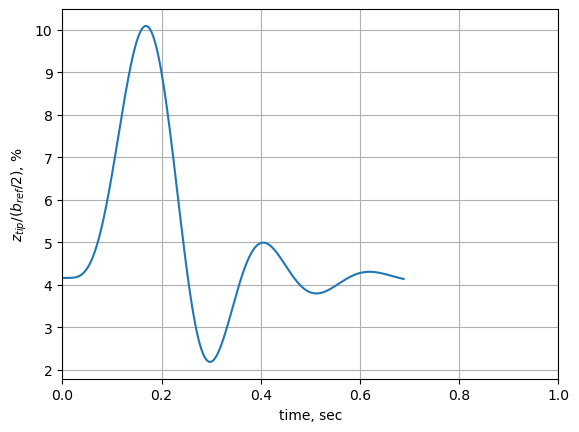

In [10]:
def get_resulting_vertical_tip_displacement(output_folder, model):    
    file_results = os.path.join(output_folder, 
                                 model.case_name, 
                                 'WriteVariablesTime',
                                 'struct_pos_node{}.dat'.format(model.num_node_surf))
    vertical_tip_displacement = np.loadtxt(file_results)[:,-1]
    
                                             
    return vertical_tip_displacement


tip_displacement_open_loop = get_resulting_vertical_tip_displacement(output_folder, 
                                                                     pazy_model_open_loop)


time_array = np.arange(0, len(tip_displacement_open_loop) * pazy_model_open_loop.dt, pazy_model_open_loop.dt)
normalised_tip_displacement = tip_displacement_open_loop/ (0.5*pazy_model_open_loop.b_ref) #normalise by half wing span
normalised_tip_displacement *=100# cconvert to percentnvert to percent
plt.plot(time_array, normalised_tip_displacement)
plt.xlabel('time, sec')
plt.ylabel('$z_{tip}/(b_{ref}/2)$, %')
plt.xlim([0., simulation_time])
plt.grid()
plt.show()

## Generate linear ROM

We continue with the linearization of the nonlinear aeroelastic model of the Pazy wing at the previous defined operational point and a subsequent reduction of the resulting linear state-space system. The structural and aerodynamic model are linearized and reduced separately, and finally couple both resulting linear systems. Please see [2] for more details. 

### Define Simulation Settings
We can re-use the simulation settings from the open-case with a few exception. Besides the name of course, we need to extend the simulation `flow` list by the solvers needed for the linearization and export of the resulting linear state-space system. Further, we need to change the simulation time as we need to run only on simulation timestep of the `DynamicCoupled` solver before the linearization. Also, no gust encounter is needed as we linarize the model around its equlibirum during steady-flight conditions.

In [11]:
case_name = 'pazy_ROM'

flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        'Modal',
        'LinearAssembler',
        'SaveData',
        ]

simulation_time_ROM = pazy_model_open_loop.dt # only one timestep has to be performed
gust = False

We further need to define the method used to reduce the linearized aerodynamic model. Here, we are going to apply a Krylov-based model order reduction scheme for the aerodynamic system, see [4] for more information. Please note that this is only one of the reduction methods implemented in SHARPy. Checkout LINK for the implemented alternative methods.

In [12]:
use_rom = True
rom_settings = {
    'use': use_rom,
    'rom_method': 'Krylov',
    'rom_method_settings': {'Krylov': {
                                        'algorithm': 'mimo_rational_arnoldi',
                                        'r': 4, 
                                        'frequency': np.array([0]),
                                        'single_side': 'observability',
                                        },
                           }
                }

The linearised structural model is 

In [13]:
num_modes = 20


In [14]:
unsteady_force_distribution = False

In [15]:
remove_gust_input_in_statespace = False

### Generate Input Files

In [16]:
pazy_model_ROM = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time_ROM,)

generate_aero_and_fem_input_files(pazy_model_ROM)


In [17]:
pazy_model_ROM.set_default_config_dict()
pazy_model_ROM.config = get_settings_udp(pazy_model_ROM,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings,
                            num_modes = num_modes,
                            rom_settings = rom_settings,
                            remove_gust_input_in_statespace=remove_gust_input_in_statespace,
                            unsteady_force_distribution=unsteady_force_distribution)
pazy_model_ROM.config.write()

### Run SHARPy Simulation

In [48]:
# TODO: Delete Output Folder
sharpy.sharpy_main.main(['', pazy_model_ROM.route + pazy_model_ROM.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/sdue

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0277  |  0.0000  |  1.9185  |  0.0000  |  0.0387  | -0.0000  |
|  1  |  0  |  -6.69935  | -0.0290  |  0.0000  |  1.9636  |  0.0000  |  0.0396  | -0.0000  |
|  0  |  1  |  0.00000   | -0.0566  |  0.0000  |  3.9396  | -0.0000  |  0.0794  | -0.0000  |
|  1  |  1  |  -6.06871  | -0.0592  |  0.0000  |  4.0325  | -0.0000  |  0.0812  | -0.0000  |
|  0  |  2  |  0.00000   | -0.0866  |  0.0000  |  6.0718  | -0.0000  |  0.1222  | -0.0000  |
|  1  |  2  |  -5.68671  | -0.0906  |  0.0000  |  6.2157  | -0.0000  |  0.1250  | -0.0000  |
|  0  |  3  |  0.00000   | -0.1177  |  0.0000  |  8.3244  | -0.0000  |  0.1673  | -0.0000  |
|  1  |  3  |  -5.40580  | -0.1233  |  0.0000  |  8.5230  | -0.0000  |  0.1712  | -0.0000  |
|  0  |  4  |  0.00000   | -0.1501  |  0.0000  | 10.7075  | -0.0000  |  0.2149  | -0.0000  |
|  1  |  4  |  -5.17976  | -0.1572  |  0.0000  | 10.9648  | -0.0000  |  0.2200  | -0.0000  |
Generating an instance of DynamicCoupled
Variable controller_id has no

			...done in 0.17 sec
Generating an instance of Krylov
Variable print_info has no assigned value in the settings file.
    will default to the value: True
Variable tangent_input_file has no assigned value in the settings file.
    will default to the value: 
Variable restart_arnoldi has no assigned value in the settings file.
    will default to the value: False
Initialising Krylov Model Order Reduction
State-space realisation of UVLM equations started...
Computing wake propagation matrix with CFL1=True
	state-space model produced in form:
			h_{n+1} = A h_{n} + B u_{n}
			with:
	x_n = h_n + Bp u_n
			...done in 0.63 sec
Aero surface 0
Gust monitoring station domain:
[-0.03849414 -0.0133916   0.01171094  0.03681347  0.06191601]
Vertex info: i_n = 0	i_m = 0
	Coordinate: [-3.84941363e-02  5.59595324e-18  6.71917996e-04]
	Projected coordinate: -0.038494136257435925
	Interpolation weights: [1. 0.]
	C matrix column indices: (0, 1)
	i_vertex: [0, 45, 90]
Vertex info: i_n = 0	i_m = 1
	Coordi

/home/sduess/anaconda3/envs/sharpy/lib/python3.10/site-packages/sharpy/linear/src/lingebm.py:313: UserWarning: Euler parametrisation not implemented - Either rigid body modes are not being used or this method has already been called.
  warnings.warn('Euler parametrisation not implemented - Either rigid body modes are not being used or this '



Linearising gravity terms...
	M = 0.00 kg
	X_CG A -> -0.26 0.17 0.00
Node  1 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.069 0.001
			-> G 0.000 0.069 0.001
	Node mass:
		Matrix: 0.0403
Node  2 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.137 0.002
			-> G 0.000 0.137 0.002
	Node mass:
		Matrix: 0.0202
Node  3 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.206 0.005
			-> G 0.000 0.206 0.005
	Node mass:
		Matrix: 0.0403
Node  4 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.275 0.008
			-> G 0.000 0.275 0.008
	Node mass:
		Matrix: 0.0202
Node  5 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.344 0.012
			-> G 0.000 0.344 0.012
	Node mass:
		Matrix: 0.0403
Node  6 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.412 0.015
			-> G 0.001 0.412 0.015
	Node mass:
		Matrix: 0.0202
Node  7 	-> B -0.000 -0.000 -0.000
			-> A 0.000 0.481 0.019
			-> G 0.001 0.481 0.019
	Node mass:
		Matrix: 0.0403
Node  8 	-> B 0.003 -0.004 -0.000
			-> A 0.004 0.553 0.023
			-> G 0.005 0.553 0.023
	Node mass:
		Matrix: 0.0300
Nod

FINISHED - Elapsed time = 20.7941866 seconds
FINISHED - CPU process time = 227.4375586 seconds


### Prepare Linear System for specific Controller
An overview about the generated linear ROM can be found near the end of the log-file, including number of states, inputs, and outputs as well as the indices mapped to each parameter. The saved linear ROM contains several unused input and output variables. 

We start with reading the matrices from the h5 file and get rid of all unused input and output variables that are not needed for the control design. More precisely, we keep the gust and control surface inputs as well as the vertical tip displacements as an outputs. 

delta and delta dog

Subsequently, we simulate the open-loop and closed-loop responses for different proportional gains of the P-controller.

First, we save some parameters needed for this to a dict 

In [18]:
folder_linear_results =os.path.join(output_folder, pazy_model_ROM.case_name,'linear_results')
if not os.path.exists(folder_linear_results):
    os.makedirs(folder_linear_results)
    
import scipy.io

parameter_matlab = {'num_aero_states': 80, # see log file
                    'num_modes': 20,  # see log file
                     'u_inf': float(pazy_model_ROM.u_inf),
                    'simulation_time': simulation_time,
                    'gust_length': float(gust_settings['gust_length']),
                    'gust_intensity': float(gust_settings['gust_intensity']),
                    'num_control_surfaces': num_control_surfaces,
                    'n_nodes': number_spanwise_nodes,
                    'control_input_start': 193 + 1, # see log file and + 1 for matlab indices
                    'gust_input_start': 192 + 1 , # see log file and + 1 for matlab indices
                   }

scipy.io.savemat(os.path.join(folder_linear_results, 'simulation_parameters.mat'), parameter_matlab)

Next, we open Matlab and run the script *control_design_script.m* from the path

In [19]:
route_notebook_dir

'/home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control'

### Postprocessing
Now, let us have a look at the linear results generated:

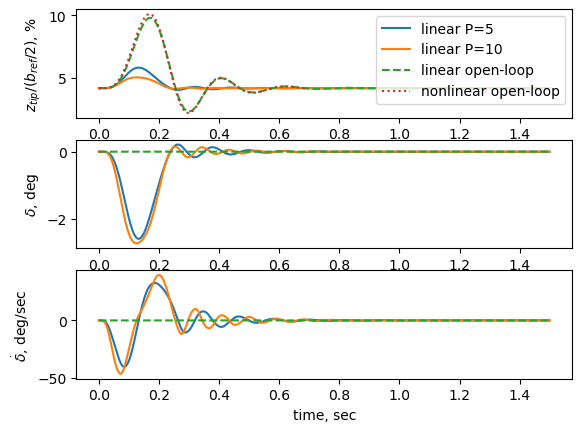

In [20]:
# Load linear results
tip_deflection_linear = np.loadtxt(folder_linear_results + '/tip_deflection.txt', delimiter = ',')
time_array_linear = np.loadtxt(folder_linear_results + '/time_array_linear.txt', delimiter = ',')
normalised_tip_deflection_linear = tip_deflection_linear / (0.5 *pazy_model_ROM.b_ref) * 100
control_surface_deflection_deg = np.loadtxt(folder_linear_results + '/deflection.txt', delimiter = ',')
control_surface_deflection_rate_deg = np.loadtxt(folder_linear_results + '/deflection_rate.txt', delimiter = ',')

# Plot Data
fig, axs = plt.subplots(3, 1)
list_linestyles = ['-', '-', '--', ':']
list_labels = ['linear P=5', 'linear P=10', 'linear open-loop', 'nonlinear open-loop']
for i in range(3):
    axs[0].plot(time_array_linear, normalised_tip_deflection_linear[:,i], list_linestyles[i], label=list_labels[i])

axs[0].plot(time_array, normalised_tip_displacement, list_linestyles[-1], label=list_labels[-1])
axs[0].legend()
axs[0].set(ylabel='$z_{tip}/(b_{ref}/2)$, %')

for i in range(3):
    axs[1].plot(time_array_linear, control_surface_deflection_deg[:,i], list_linestyles[i])
    
axs[1].set(ylabel='$\delta$, deg')
for i in range(3):
    axs[2].plot(time_array_linear, control_surface_deflection_rate_deg[:,i], list_linestyles[i])
    
axs[2].set(ylabel='$\dot{\delta}$, deg/sec')
for ax in axs.flat:
    ax.set(xlabel='time, sec')


We see

## Closed-Loop Nonlinear Gust Response

In [21]:
case_name = 'pazy_udp_closed_loop_gust_response'
gust = True
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        ]

In [22]:
initial_cs_deflection = 0
cs_type = 2 

In [23]:
pazy_model_closed = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      initial_cs_deflection=initial_cs_deflection,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,
                                      cs_type=cs_type)
generate_aero_and_fem_input_files(pazy_model_closed)

In [24]:
#  Network settings for nonlinear in closed-loop simulations   
server_ip_addr = '127.0.0.1' # SHARPy
client_ip_addr = '127.0.0.1' # controller
port_in_network = 64016
port_out_network_server = 59016
port_out_network_client = 59006      
network_settings = {'variables_filename': route_notebook_dir + '/pazy_network_info.yml', # TODO: explain in text, write yml file depending on number of spanwise nodes
                                        'send_output_to_all_clients': False,
                                        'byte_ordering': 'little',
                                        'log_name': output_folder +'/'+ case_name + '/sharpy_network.log',
                                        'file_log_level': 'debug',
                                        'console_log_level': 'debug',
                                        'input_network_settings': {'address': server_ip_addr,
                                                                        'port': port_in_network,
                                                                        },
                                        'output_network_settings': {'send_on_demand': False,
                                                                        'port': port_out_network_server,
                                                                        'address':server_ip_addr, 
                                                                        'destination_address': [client_ip_addr],
                                                                        'destination_ports': [port_out_network_client],
                                                                }
                                                }



In [25]:
num_sensors = 1

In [26]:
pazy_model_closed.set_default_config_dict()
pazy_model_closed.config = get_settings_udp(pazy_model_closed,
                            flow,
                            network_settings=network_settings,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings)
pazy_model_closed.config.write()

Start simulation and controller and UDP-interface,
write necessary parameters to file

In [27]:
tip_displacement_open_loop[0]


0.02290911

In [28]:

dict_parameters = {"server_ip_addr": server_ip_addr,
                   "client_ip_addr": client_ip_addr,
                   "port_in_network": port_in_network,
                   "port_out_network_server": port_out_network_server,
                   "port_out_network_client": port_out_network_client,
                   "output_folder": os.path.abspath(output_folder),
                   "dt": pazy_model_closed.dt,
                   "simulation_time": simulation_time,
                   "num_sensors": num_sensors,
                   "initial_cs_deflection": initial_cs_deflection,
                   "reference_deflection": tip_displacement_open_loop[0],
                  }
with open('./parameter_UDP_control_{}.json'.format(pazy_model_closed.case_name), 'w') as fp:
    json.dump(dict_parameters, fp)

In [ ]:
sharpy.sharpy_main.main(['', pazy_model_closed.route + pazy_model_closed.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/sduess/Documents/SHARPY_simulations/body-freedom_flutter_analysis/lib/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/sdue

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0277  |  0.0000  |  1.9185  |  0.0000  |  0.0387  | -0.0000  |
|  1  |  0  |  -6.69935  | -0.0290  |  0.0000  |  1.9636  |  0.0000  |  0.0396  | -0.0000  |
|  0  |  1  |  0.00000   | -0.0566  |  0.0000  |  3.9396  | -0.0000  |  0.0794  | -0.0000  |
|  1  |  1  |  -6.06871  | -0.0592  |  0.0000  |  4.0325  | -0.0000  |  0.0812  | -0.0000  |
|  0  |  2  |  0.00000   | -0.0866  |  0.0000  |  6.0718  | -0.0000  |  0.1222  | -0.0000  |
|  1  |  2  |  -5.68671  | -0.0906  |  0.0000  |  6.2157  | -0.0000  |  0.1250  | -0.0000  |
|  0  |  3  |  0.00000   | -0.1177  |  0.0000  |  8.3244  | -0.0000  |  0.1673  | -0.0000  |
|  1  |  3  |  -5.40580  | -0.1233  |  0.0000  |  8.5230  | -0.0000  |  0.1712  | -0.0000  |
|  0  |  4  |  0.00000   | -0.1501  |  0.0000  | 10.7075  | -0.0000  |  0.2149  | -0.0000  |


2023-06-20 21:24:24,921 - sharpy.io.network_interface - INFO - Initialising Network Interface. Local host name: sduess-HP-ZBook-Firefly-15-G7-Mobile-Workstation
2023-06-20 21:24:24,926 - sharpy.io.inout_variables - INFO - Loaded variable control_surface_deflection_idx0
2023-06-20 21:24:24,927 - sharpy.io.inout_variables - DEBUG - Number of tracked variables 1
2023-06-20 21:24:24,927 - sharpy.io.inout_variables - INFO - Loaded variable control_surface_deflection_idx1
2023-06-20 21:24:24,929 - sharpy.io.inout_variables - DEBUG - Number of tracked variables 2
2023-06-20 21:24:24,930 - sharpy.io.inout_variables - INFO - Loaded variable pos_node8_index2
2023-06-20 21:24:24,931 - sharpy.io.inout_variables - DEBUG - Number of tracked variables 3
2023-06-20 21:24:24,933 - sharpy.io.network_interface - INFO - Initialising output network
2023-06-20 21:24:24,934 - sharpy.solvers.dynamiccoupled - DEBUG - Inside time loop
2023-06-20 21:24:24,935 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - 

|  1  |  4  |  -5.17976  | -0.1572  |  0.0000  | 10.9648  | -0.0000  |  0.2200  | -0.0000  |
Generating an instance of DynamicCoupled
Variable controller_id has no assigned value in the settings file.
    will default to the value: {}
Variable controller_settings has no assigned value in the settings file.
    will default to the value: {}
Variable steps_without_unsteady_force has no assigned value in the settings file.
    will default to the value: 0
Variable pseudosteps_ramp_unsteady_force has no assigned value in the settings file.
    will default to the value: 0
Variable correct_forces_method has no assigned value in the settings file.
    will default to the value: 
Variable correct_forces_settings has no assigned value in the settings file.
    will default to the value: {}
Variable runtime_generators has no assigned value in the settings file.
    will default to the value: {}
Generating an instance of NonLinearDynamicPrescribedStep
Generating an instance of StepUvlm
Variable 

2023-06-20 21:25:22,782 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:25:22,783 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 21:25:22,784 - sharpy.io.network_interface - INFO - Added new client to list ('127.0.0.1', 58998)
2023-06-20 21:25:22,784 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 21:25:22,785 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 21:25:22,786 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, 0.0), (1, 0.0)]
2023-06-20 21:25:22,850 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 21:25:22,926 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to 0.0000
2023-06-20 21:25:22,933 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to 0.0000
2023-06-20 

|   1   | 0.0006 |  5   |   0.969525   |  83.917599   |  -6.417216   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:25:50,144 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:25:50,150 - sharpy.io.inout_variables - DEBUG - Getting value 0.022909090484252066 for variable pos_node8_index2
2023-06-20 21:25:50,162 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input
2023-06-20 21:25:50,162 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:25:50,164 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:25:50,165 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:25:50,166 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:25:50,167 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:25:50,168 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:25:50,169 - sharpy.io.network_interface - INFO - Network - Sent data 

|   2   | 0.0013 |  4   |   0.967888   |  13.382831   |  -6.496224   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:03,868 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:26:03,871 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:26:03,873 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:26:03,874 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:26:03,877 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:26:03,881 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:26:03,883 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:26:03,885 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:26:03,888 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:26:03,891 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|   3   | 0.0019 |  3   |   0.958401   |   7.038933   |  -6.173354   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:17,678 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:26:17,679 - sharpy.io.inout_variables - DEBUG - Getting value 0.022909112147251564 for variable pos_node8_index2
2023-06-20 21:26:17,680 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|   4   | 0.0025 |  3   |   0.967330   |   6.657124   |  -6.020512   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:17,925 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:26:17,926 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:26:17,927 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:26:17,927 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:26:17,928 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:26:17,929 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:26:17,930 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:26:17,931 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:26:17,931 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:26:17,932 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|   5   | 0.0031 |  4   |   0.966367   |   7.706774   |  -6.536089   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:25,943 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:26:25,945 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:26:25,952 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:26:25,955 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:26:25,956 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:26:25,958 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:26:25,960 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:26:25,964 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:26:25,966 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:26:25,969 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|   6   | 0.0037 |  4   |   0.967534   |   8.174859   |  -6.365511   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:33,980 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:26:33,981 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:26:33,982 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:26:33,983 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:26:33,983 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:26:33,984 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:26:33,985 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:26:33,986 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:26:33,987 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:26:33,988 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|   7   | 0.0044 |  4   |   0.960491   |   8.248158   |  -6.233104   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:42,999 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:26:43,001 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:26:43,003 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:26:43,005 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:26:43,007 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:26:43,008 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:26:43,009 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:26:43,010 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:26:43,010 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:26:43,011 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|   8   | 0.0050 |  4   |   0.962127   |   7.357773   |  -6.162202   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:50,027 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:26:50,030 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:26:50,037 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:26:50,039 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:26:50,041 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:26:50,043 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:26:50,045 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:26:50,046 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:26:50,049 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:26:50,053 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|   9   | 0.0056 |  4   |   0.941456   |   7.747618   |  -6.112826   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:26:58,069 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:26:58,071 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:26:58,073 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:26:58,076 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:26:58,077 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:26:58,078 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:26:58,078 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:26:58,079 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:26:58,080 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:26:58,081 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  10   | 0.0063 |  4   |   0.959963   |   6.655901   |  -6.081812   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:27:05,091 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:27:05,093 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:27:05,095 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:27:05,097 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:27:05,098 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:27:05,099 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:27:05,100 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:27:05,101 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:27:05,102 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:27:05,103 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  11   | 0.0069 |  4   |   0.963771   |   7.609228   |  -6.037509   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:27:13,113 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:27:13,115 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:27:13,116 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:27:13,118 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:27:13,120 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:27:13,122 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:27:13,125 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:27:13,126 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:27:13,127 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:27:13,128 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  12   | 0.0075 |  5   |   0.947199   |   8.056920   |  -6.726737   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:27:21,139 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:27:21,141 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:27:21,143 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:27:21,143 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:27:21,144 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:27:21,145 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:27:21,146 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:27:21,146 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:27:21,147 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:27:21,148 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  13   | 0.0081 |  5   |   0.957334   |   9.250807   |  -6.700344   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:27:30,159 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:27:30,160 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:27:30,161 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:27:30,162 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:27:30,163 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:27:30,164 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:27:30,165 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:27:30,166 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:27:30,167 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:27:30,168 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  14   | 0.0088 |  5   |   0.946576   |   8.152631   |  -6.664563   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:27:38,179 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:27:38,180 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:27:38,181 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:27:38,182 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:27:38,183 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:27:38,184 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:27:38,185 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:27:38,186 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:27:38,187 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:27:38,188 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  15   | 0.0094 |  5   |   0.962543   |  10.534727   |  -6.618376   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:27:49,201 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:27:49,203 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:27:49,205 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:27:49,206 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:27:49,208 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:27:49,209 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:27:49,210 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:27:49,211 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:27:49,211 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:27:49,212 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  16   | 0.0100 |  5   |   0.960914   |  10.756244   |  -6.570159   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:28:00,224 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:28:00,225 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:28:00,226 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:28:00,227 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:28:00,228 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:28:00,229 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:28:00,229 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:28:00,230 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:28:00,231 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:28:00,232 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  17   | 0.0106 |  5   |   0.960233   |  11.934016   |  -6.527703   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:28:12,246 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:28:12,247 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:28:12,248 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:28:12,248 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:28:12,249 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:28:12,250 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:28:12,252 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:28:12,252 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:28:12,254 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:28:12,255 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  18   | 0.0112 |  5   |   0.950211   |   9.389000   |  -6.488940   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:28:21,273 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:28:21,274 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:28:21,275 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 21:28:21,276 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 21:28:21,277 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 21:28:21,278 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -2.380460500717163e-05), (1, -2.380460500717163e-05)]
2023-06-20 21:28:21,279 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 21:28:21,280 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to -0.0000
2023-06-20 21:28:21,281 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to 

|  19   | 0.0119 |  5   |   0.964640   |  10.490484   |  -6.452650   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:28:32,289 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:28:32,290 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:28:32,290 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:28:32,292 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:28:32,292 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:28:32,293 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:28:32,294 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:28:32,295 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:28:32,296 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:28:32,297 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  20   | 0.0125 |  5   |   0.967338   |  11.477426   |  -6.425763   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:28:44,312 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:28:44,313 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:28:44,313 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:28:44,314 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:28:44,315 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:28:44,316 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:28:44,317 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:28:44,318 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:28:44,318 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:28:44,319 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  21   | 0.0131 |  5   |   0.960963   |   9.058796   |  -6.403233   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:28:53,332 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:28:53,334 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:28:53,337 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:28:53,339 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:28:53,340 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:28:53,341 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:28:53,342 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:28:53,343 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:28:53,344 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:28:53,344 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  22   | 0.0138 |  5   |   0.962299   |   9.553054   |  -6.380830   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:29:03,374 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:29:03,376 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:29:03,377 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:29:03,379 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:29:03,381 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:29:03,383 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:29:03,384 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:29:03,386 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:29:03,388 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:29:03,389 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  23   | 0.0144 |  5   |   0.951527   |  10.167408   |  -6.363826   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:29:13,412 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:29:13,414 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:29:13,416 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:29:13,420 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:29:13,421 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:29:13,424 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:29:13,425 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:29:13,429 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:29:13,432 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:29:13,434 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  24   | 0.0150 |  5   |   0.955843   |   8.706032   |  -6.346719   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:29:22,450 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:29:22,452 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:29:22,454 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:29:22,455 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:29:22,457 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:29:22,460 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:29:22,462 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:29:22,464 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:29:22,466 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:29:22,469 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  25   | 0.0156 |  5   |   0.944104   |   8.528935   |  -6.321845   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:29:30,484 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:29:30,486 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:29:30,488 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:29:30,491 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:29:30,494 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:29:30,496 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:29:30,499 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:29:30,502 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:29:30,504 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:29:30,506 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  26   | 0.0163 |  5   |   0.957733   |   8.463008   |  -6.292107   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:29:39,516 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:29:39,518 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:29:39,519 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:29:39,521 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:29:39,524 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:29:39,526 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:29:39,527 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:29:39,530 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:29:39,532 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:29:39,533 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  27   | 0.0169 |  5   |   0.954476   |   8.019195   |  -6.264420   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:29:47,544 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:29:47,546 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:29:47,548 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:29:47,549 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:29:47,551 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:29:47,552 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:29:47,554 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:29:47,556 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:29:47,559 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:29:47,559 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  28   | 0.0175 |  5   |   0.957032   |   8.047244   |  -6.242272   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:29:55,569 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:29:55,570 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:29:55,571 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:29:55,571 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:29:55,572 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:29:55,573 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:29:55,574 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:29:55,574 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:29:55,575 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:29:55,576 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  29   | 0.0181 |  5   |   0.955285   |   7.961754   |  -6.224160   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:30:03,586 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:30:03,587 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:30:03,588 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:30:03,589 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:30:03,590 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:30:03,591 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:30:03,592 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:30:03,592 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:30:03,593 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:30:03,594 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  30   | 0.0187 |  5   |   0.952160   |   7.651918   |  -6.207841   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:30:11,602 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:30:11,605 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:30:11,606 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:30:11,608 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:30:11,609 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:30:11,611 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:30:11,613 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:30:11,615 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:30:11,618 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:30:11,620 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  31   | 0.0194 |  5   |   0.963877   |  10.625086   |  -6.194854   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:30:22,640 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:30:22,642 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:30:22,645 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:30:22,646 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:30:22,648 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:30:22,650 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:30:22,651 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:30:22,654 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:30:22,655 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:30:22,656 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  32   | 0.0200 |  5   |   0.963331   |  10.151608   |  -6.184476   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:30:32,673 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:30:32,674 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:30:32,675 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:30:32,676 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:30:32,677 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:30:32,678 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:30:32,679 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:30:32,680 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:30:32,681 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:30:32,682 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  33   | 0.0206 |  5   |   0.958273   |  11.252899   |  -6.172807   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:30:43,714 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:30:43,717 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:30:43,721 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:30:43,722 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:30:43,724 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:30:43,727 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 21:30:43,729 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 21:30:43,731 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 21:30:43,732 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.0002181529998779297), (1, -0.0002181529998779297)]
2023-06-20 21:30:43,736 - sharpy.

|  34   | 0.0213 |  5   |   0.969422   |  14.200850   |  -6.161130   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:30:58,749 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:30:58,750 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:30:58,751 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:30:58,752 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:30:58,753 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:30:58,754 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:30:58,754 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:30:58,756 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:30:58,757 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:30:58,757 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  35   | 0.0219 |  5   |   0.973449   |  16.591594   |  -6.149066   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:31:14,783 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:31:14,784 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:31:14,786 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:31:14,787 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:31:14,788 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:31:14,790 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 21:31:14,791 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 21:31:14,793 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 21:31:14,793 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.0002835318446159363), (1, -0.0002835318446159363)]
2023-06-20 21:31:14,795 - sharpy.

|  36   | 0.0225 |  5   |   0.972034   |  13.982843   |  -6.133906   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:31:29,824 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:31:29,825 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:31:29,825 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:31:29,826 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:31:29,827 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:31:29,828 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:31:29,828 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:31:29,830 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:31:29,830 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:31:29,831 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  37   | 0.0231 |  5   |   0.966539   |  13.704784   |  -6.116688   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:31:42,845 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:31:42,846 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:31:42,847 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:31:42,847 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:31:42,848 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:31:42,848 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:31:42,849 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:31:42,850 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:31:42,851 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:31:42,851 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  38   | 0.0238 |  5   |   0.961915   |   9.621082   |  -6.103015   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:31:52,864 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:31:52,866 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:31:52,867 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:31:52,870 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:31:52,873 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:31:52,875 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:31:52,876 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:31:52,878 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:31:52,880 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:31:52,882 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  39   | 0.0244 |  5   |   0.960192   |   8.702071   |  -6.094653   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:32:01,897 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:32:01,898 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:32:01,899 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:32:01,900 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:32:01,900 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:32:01,901 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:32:01,903 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:32:01,904 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:32:01,904 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:32:01,906 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  40   | 0.0250 |  5   |   0.960518   |   9.700105   |  -6.088163   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:32:11,918 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:32:11,919 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:32:11,927 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:32:11,928 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:32:11,929 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:32:11,930 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:32:11,931 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:32:11,931 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:32:11,932 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:32:11,933 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  41   | 0.0256 |  5   |   0.956427   |   8.638910   |  -6.081941   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:32:29,672 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:32:29,673 - sharpy.io.inout_variables - DEBUG - Getting value 0.02297428306664968 for variable pos_node8_index2
2023-06-20 21:32:29,674 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  42   | 0.0262 |  5   |   0.955599   |   9.622587   |  -6.076326   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:32:29,970 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:32:29,970 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:32:29,971 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:32:29,972 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:32:29,973 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:32:29,974 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:32:29,975 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:32:29,976 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:32:29,976 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:32:29,977 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  43   | 0.0269 |  5   |   0.958036   |  11.926368   |  -6.069892   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:32:41,992 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:32:41,994 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:32:41,996 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:32:41,998 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:32:41,999 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:32:41,999 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:32:42,000 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:32:42,002 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:32:42,002 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:32:42,003 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  44   | 0.0275 |  5   |   0.963259   |  12.084620   |  -6.062712   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:33:03,260 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:33:03,261 - sharpy.io.inout_variables - DEBUG - Getting value 0.02299855236909879 for variable pos_node8_index2
2023-06-20 21:33:03,262 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  45   | 0.0281 |  5   |   0.955628   |   9.095745   |  -6.056066   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:33:04,041 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:33:04,043 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:33:04,051 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:33:04,053 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:33:04,055 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:33:04,056 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:33:04,059 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:33:04,061 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:33:04,064 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:33:04,067 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  46   | 0.0288 |  5   |   0.967313   |  11.431560   |  -6.049237   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:33:15,083 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:33:15,084 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:33:15,085 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:33:15,085 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:33:15,086 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:33:15,087 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:33:15,088 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:33:15,089 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:33:15,090 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:33:15,090 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  47   | 0.0294 |  5   |   0.965957   |  10.535472   |  -6.041418   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:33:26,103 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:33:26,105 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:33:26,108 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:33:26,109 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:33:26,111 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:33:26,113 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:33:26,114 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:33:26,116 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:33:26,120 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:33:26,122 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  48   | 0.0300 |  5   |   0.970936   |  15.930827   |  -6.033602   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:33:42,143 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:33:42,145 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:33:42,147 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:33:42,149 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:33:42,151 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:33:42,152 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:33:42,153 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:33:42,153 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:33:42,154 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:33:42,155 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  49   | 0.0306 |  5   |   0.960252   |  11.424093   |  -6.027748   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:34:03,883 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:34:03,885 - sharpy.io.inout_variables - DEBUG - Getting value 0.02305400713451968 for variable pos_node8_index2
2023-06-20 21:34:03,886 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  50   | 0.0312 |  5   |   0.956641   |  10.551299   |  -6.026361   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:34:04,193 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:34:04,194 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:34:04,194 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:34:04,195 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:34:04,195 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:34:04,196 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:34:04,197 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:34:04,198 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:34:04,199 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:34:04,200 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  51   | 0.0319 |  5   |   0.957529   |   9.000299   |  -6.025593   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:34:13,212 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:34:13,214 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:34:13,216 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:34:13,217 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:34:13,220 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:34:13,222 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:34:13,224 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:34:13,229 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:34:13,231 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:34:13,232 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  52   | 0.0325 |  5   |   0.951732   |   8.851769   |  -6.021597   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:34:22,247 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:34:22,248 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:34:22,248 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:34:22,249 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:34:22,250 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:34:22,250 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:34:22,251 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:34:22,252 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:34:22,253 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:34:22,254 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  53   | 0.0331 |  5   |   0.949053   |  10.982456   |  -6.016314   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:34:33,267 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:34:33,268 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:34:33,269 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:34:33,270 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:34:33,271 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:34:33,272 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:34:33,273 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:34:33,274 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:34:33,276 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:34:33,277 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  54   | 0.0338 |  5   |   0.969400   |  13.939176   |  -6.010397   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:34:54,698 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:34:54,700 - sharpy.io.inout_variables - DEBUG - Getting value 0.023131438884163205 for variable pos_node8_index2
2023-06-20 21:34:54,701 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  55   | 0.0344 |  5   |   0.938723   |   7.320479   |  -6.003505   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:34:55,317 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:34:55,319 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:34:55,320 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:34:55,321 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:34:55,323 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:34:55,326 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:34:55,328 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:34:55,329 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:34:55,331 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:34:55,333 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  56   | 0.0350 |  6   |   0.956977   |  10.432576   |  -6.730132   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:35:05,350 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:35:05,351 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:35:05,352 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:35:05,352 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:35:05,354 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:35:05,355 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:35:05,356 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:35:05,357 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:35:05,358 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:35:05,359 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  57   | 0.0356 |  6   |   0.946297   |   9.028986   |  -6.725317   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:35:15,376 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:35:15,378 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:35:15,386 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:35:15,387 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:35:15,388 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:35:15,388 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:35:15,389 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:35:15,390 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:35:15,391 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:35:15,391 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  58   | 0.0362 |  6   |   0.955703   |   9.506906   |  -6.720615   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:35:24,408 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:35:24,409 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:35:24,410 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:35:24,410 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:35:24,411 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:35:24,412 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:35:24,413 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:35:24,414 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:35:24,415 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:35:24,416 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  59   | 0.0369 |  6   |   0.961490   |  13.118350   |  -6.715642   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:35:37,447 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to -0.0030
2023-06-20 21:35:37,448 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to -0.0030
2023-06-20 21:35:37,449 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 21:35:37,450 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 21:35:37,452 - sharpy.solvers.dynamiccoupled - DEBUG - Time step 60
2023-06-20 21:35:50,220 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:35:50,221 - sharpy.io.inout_variables - DEBUG - Getting value 0.02323378113255464 for variable pos_node8_index2
2023-06-20 21:35:50,222 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  60   | 0.0375 |  6   |   0.958575   |  12.685014   |  -6.713546   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:35:50,467 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:35:50,469 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:35:50,470 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:35:50,471 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:35:50,474 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:35:50,477 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:35:50,479 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:35:50,481 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:35:50,482 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:35:50,484 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  61   | 0.0381 |  6   |   0.952385   |   9.082623   |  -6.714740   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:35:59,505 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:35:59,506 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 21:35:59,508 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 21:35:59,508 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 21:35:59,509 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.003482736647129059), (1, -0.003482736647129059)]
2023-06-20 21:35:59,510 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 21:35:59,511 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to -0.0035
2023-06-20 21:35:59,512 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to -0.0035
2023-06-20 21:35:59,513 - sharpy.io.inout_variables - DEBUG - Updated control surf

|  62   | 0.0387 |  6   |   0.959320   |  10.228605   |  -6.714115   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:36:10,522 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:36:10,524 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:36:10,525 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:36:10,528 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:36:10,531 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:36:10,532 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:36:10,534 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:36:10,535 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:36:10,536 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:36:10,537 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  63   | 0.0394 |  6   |   0.954768   |  10.117758   |  -6.712810   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:36:20,549 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:36:20,550 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:36:20,551 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:36:20,552 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:36:20,552 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:36:20,553 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:36:20,554 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:36:20,555 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:36:20,556 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:36:20,557 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  64   | 0.0400 |  6   |   0.951474   |  10.476172   |  -6.706641   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:36:31,576 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:36:31,578 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:36:31,580 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:36:31,583 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:36:31,586 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:36:31,589 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:36:31,593 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:36:31,596 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:36:31,599 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:36:31,602 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  65   | 0.0406 |  6   |   0.960121   |  11.334025   |  -6.703970   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:36:42,620 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:36:42,621 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:36:42,622 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:36:42,622 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:36:42,624 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:36:42,625 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:36:42,625 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:36:42,626 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:36:42,627 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:36:42,628 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  66   | 0.0413 |  6   |   0.955890   |  10.716888   |  -6.701327   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:36:53,642 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:36:53,643 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:36:53,643 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:36:53,644 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:36:53,645 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:36:53,645 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:36:53,646 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:36:53,647 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:36:53,648 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:36:53,649 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  67   | 0.0419 |  6   |   0.945743   |   9.236033   |  -6.698924   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:37:02,661 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:37:02,663 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:37:02,665 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:37:02,667 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:37:02,669 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:37:02,671 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:37:02,673 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:37:02,676 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:37:02,678 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:37:02,680 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  68   | 0.0425 |  6   |   0.952936   |   9.568434   |  -6.697699   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:37:12,702 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:37:12,704 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:37:12,705 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:37:12,708 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:37:12,710 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:37:12,712 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:37:12,714 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:37:12,716 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:37:12,719 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:37:12,721 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  69   | 0.0431 |  6   |   0.956994   |  10.377316   |  -6.696499   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:37:33,819 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:37:33,820 - sharpy.io.inout_variables - DEBUG - Getting value 0.02352120983935289 for variable pos_node8_index2
2023-06-20 21:37:33,821 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  70   | 0.0438 |  6   |   0.952108   |  11.019693   |  -6.694716   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:37:34,764 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:37:34,765 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:37:34,766 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:37:34,767 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:37:34,768 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:37:34,769 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:37:34,770 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:37:34,771 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:37:34,772 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:37:34,773 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  71   | 0.0444 |  6   |   0.967645   |  15.384392   |  -6.694284   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:37:49,792 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:37:49,793 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:37:49,801 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:37:49,802 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:37:49,803 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:37:49,804 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:37:49,805 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:37:49,806 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:37:49,807 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:37:49,808 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  72   | 0.0450 |  6   |   0.952806   |  11.012405   |  -6.695048   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:38:00,827 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:38:00,829 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:38:00,832 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:38:00,833 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:38:00,835 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:38:00,837 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:38:00,838 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:38:00,840 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:38:00,843 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:38:00,846 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  73   | 0.0456 |  6   |   0.945706   |   9.945548   |  -6.694584   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:38:10,860 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:38:10,861 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:38:10,862 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:38:10,862 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:38:10,863 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:38:10,863 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:38:10,864 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:38:10,865 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:38:10,866 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:38:10,867 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  74   | 0.0462 |  6   |   0.950716   |   9.191732   |  -6.692061   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:38:20,883 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:38:20,884 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:38:20,885 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:38:20,886 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:38:20,887 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:38:20,888 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:38:20,890 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:38:20,891 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:38:20,892 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:38:20,893 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  75   | 0.0469 |  6   |   0.944300   |  10.378851   |  -6.689691   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:38:30,905 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:38:30,908 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:38:30,909 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:38:30,911 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:38:30,913 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:38:30,914 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:38:30,918 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:38:30,920 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:38:30,923 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:38:30,925 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  76   | 0.0475 |  6   |   0.971255   |  15.311240   |  -6.688475   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:38:55,398 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:38:55,399 - sharpy.io.inout_variables - DEBUG - Getting value 0.023791371350674294 for variable pos_node8_index2
2023-06-20 21:38:55,400 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  77   | 0.0481 |  6   |   0.950313   |   9.310953   |  -6.688436   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:38:55,972 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:38:55,974 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:38:55,976 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:38:55,979 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:38:55,980 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:38:55,981 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:38:55,983 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:38:55,984 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:38:55,985 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:38:55,986 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  78   | 0.0488 |  6   |   0.960022   |  10.961764   |  -6.689320   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:39:07,001 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:39:07,003 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:39:07,004 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:39:07,006 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:39:07,007 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:39:07,009 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:39:07,010 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:39:07,010 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:39:07,011 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:39:07,012 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  79   | 0.0494 |  6   |   0.949025   |   8.845111   |  -6.690619   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:39:16,028 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:39:16,029 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:39:16,030 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:39:16,031 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:39:16,032 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:39:16,032 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:39:16,034 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:39:16,035 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:39:16,036 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:39:16,036 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  80   | 0.0500 |  6   |   0.961476   |  12.690522   |  -6.692099   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:39:29,052 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:39:29,054 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:39:29,057 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:39:29,060 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:39:29,061 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:39:29,061 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:39:29,062 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:39:29,063 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:39:29,064 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:39:29,065 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  81   | 0.0506 |  6   |   0.971465   |  18.527530   |  -6.693496   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:39:47,097 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:39:47,099 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:39:47,100 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:39:47,102 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:39:47,105 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:39:47,107 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:39:47,109 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:39:47,112 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:39:47,114 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:39:47,116 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  82   | 0.0513 |  6   |   0.957734   |  11.077852   |  -6.693837   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:39:59,136 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:39:59,138 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:39:59,140 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:39:59,143 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:39:59,145 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:39:59,147 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:39:59,148 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:39:59,149 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:39:59,150 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:39:59,151 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  83   | 0.0519 |  6   |   0.950967   |  10.869023   |  -6.695712   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:40:10,164 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:40:10,165 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:40:10,166 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:40:10,167 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:40:10,168 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:40:10,169 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:40:10,169 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:40:10,170 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:40:10,172 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:40:10,172 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  84   | 0.0525 |  6   |   0.953406   |   9.863753   |  -6.696703   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:40:20,199 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:40:20,201 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:40:20,202 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:40:20,204 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:40:20,206 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:40:20,207 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:40:20,209 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:40:20,210 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:40:20,211 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:40:20,212 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  85   | 0.0531 |  6   |   0.959926   |  11.567154   |  -6.693888   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:40:31,226 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:40:31,226 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:40:31,227 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:40:31,228 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:40:31,228 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:40:31,230 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:40:31,231 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:40:31,232 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:40:31,232 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:40:31,233 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  86   | 0.0537 |  6   |   0.950714   |   9.097164   |  -6.692170   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:41:26,605 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:41:26,606 - sharpy.io.inout_variables - DEBUG - Getting value 0.024274730467025996 for variable pos_node8_index2
2023-06-20 21:41:26,607 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  87   | 0.0544 |  6   |   0.986645   |  46.282697   |  -6.693426   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:41:27,302 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:41:27,303 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:41:27,304 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:41:27,304 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:41:27,305 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:41:27,306 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:41:27,308 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:41:27,308 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:41:27,309 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:41:27,311 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  88   | 0.0550 |  6   |   0.984910   |  41.199101   |  -6.693033   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:42:08,362 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:42:08,363 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:42:08,363 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:42:08,364 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:42:08,365 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:42:08,365 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:42:08,366 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:42:08,367 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:42:08,368 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:42:08,369 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  89   | 0.0556 |  6   |   0.980928   |  25.009034   |  -6.692644   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:42:33,393 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:42:33,395 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:42:33,395 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:42:33,396 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:42:33,397 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:42:33,397 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:42:33,399 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:42:33,399 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:42:33,400 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:42:33,401 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  90   | 0.0563 |  6   |   0.976426   |  23.604048   |  -6.692003   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:42:57,428 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:42:57,429 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:42:57,429 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:42:57,430 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:42:57,431 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:42:57,432 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:42:57,433 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:42:57,433 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:42:57,434 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:42:57,435 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  91   | 0.0569 |  6   |   0.981050   |  29.508763   |  -6.691264   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:43:27,474 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:43:27,475 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:43:27,476 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:43:27,476 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:43:27,477 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:43:27,478 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:43:27,478 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:43:27,479 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:43:27,481 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:43:27,481 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  92   | 0.0575 |  6   |   0.977238   |  25.774882   |  -6.689890   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:43:52,509 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:43:52,510 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:43:52,511 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:43:52,512 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:43:52,513 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:43:52,514 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:43:52,515 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:43:52,517 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:43:52,518 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:43:52,520 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  93   | 0.0581 |  6   |   0.979788   |  36.410017   |  -6.688297   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:44:29,561 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:44:29,562 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:44:29,563 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:44:29,563 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:44:29,565 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:44:29,566 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:44:29,567 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:44:29,568 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:44:29,569 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:44:29,570 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  94   | 0.0588 |  6   |   0.985984   |  37.965351   |  -6.686519   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:45:07,627 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:45:07,628 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:45:07,629 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:45:07,631 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:45:07,632 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:45:07,633 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:45:07,636 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:45:07,637 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:45:07,639 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:45:07,640 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  95   | 0.0594 |  6   |   0.983045   |  44.458517   |  -6.684078   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:46:16,738 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:46:16,739 - sharpy.io.inout_variables - DEBUG - Getting value 0.024804606184509678 for variable pos_node8_index2
2023-06-20 21:46:16,740 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  96   | 0.0600 |  6   |   0.981965   |  24.940735   |  -6.680817   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:46:17,734 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:46:17,735 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:46:17,736 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:46:17,737 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:46:17,739 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:46:17,740 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:46:17,741 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:46:17,743 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:46:17,744 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:46:17,746 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  97   | 0.0606 |  6   |   0.976041   |  23.474115   |  -6.677882   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:46:40,777 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:46:40,779 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:46:40,781 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:46:40,783 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:46:40,786 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:46:40,787 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:46:40,790 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:46:40,791 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:46:40,793 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:46:40,795 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  98   | 0.0612 |  6   |   0.960527   |  11.138947   |  -6.676252   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:46:51,813 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:46:51,815 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:46:51,818 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:46:51,820 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:46:51,822 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:46:51,824 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:46:51,827 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:46:51,829 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:46:51,832 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:46:51,834 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  99   | 0.0619 |  6   |   0.974979   |  19.094957   |  -6.674801   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:47:25,432 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:47:25,434 - sharpy.io.inout_variables - DEBUG - Getting value 0.025066872163844345 for variable pos_node8_index2
2023-06-20 21:47:25,435 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  100  | 0.0625 |  6   |   0.962891   |  14.493267   |  -6.672449   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:47:25,893 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:47:25,895 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:47:25,896 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:47:25,898 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:47:25,900 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:47:25,901 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:47:25,906 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:47:25,907 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:47:25,909 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:47:25,912 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  101  | 0.0631 |  6   |   0.974120   |  17.509265   |  -6.669970   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:47:43,934 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:47:43,937 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:47:43,940 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:47:43,941 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:47:43,943 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:47:43,945 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:47:43,948 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:47:43,950 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:47:43,952 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:47:43,955 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  102  | 0.0638 |  6   |   0.964964   |  14.522987   |  -6.667357   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:47:58,000 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:47:58,001 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:47:58,002 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:47:58,003 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:47:58,004 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:47:58,005 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:47:58,006 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:47:58,008 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:47:58,008 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:47:58,009 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  103  | 0.0644 |  6   |   0.952192   |   9.099736   |  -6.663877   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:48:07,024 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:48:07,025 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:48:07,027 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:48:07,028 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:48:07,029 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 21:48:07,029 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 21:48:07,030 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 21:48:07,031 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.023644492030143738), (1, -0.023644492030143738)]
2023-06-20 21:48:07,032 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 21:48:07,033 - sharpy.io.inout_variables 

|  104  | 0.0650 |  6   |   0.949432   |   9.350971   |  -6.659838   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:48:17,041 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:48:17,043 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:48:17,050 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:48:17,051 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:48:17,051 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:48:17,052 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:48:17,053 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:48:17,054 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:48:17,055 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:48:17,057 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  105  | 0.0656 |  6   |   0.950851   |  10.857545   |  -6.656339   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:48:28,071 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:48:28,073 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:48:28,075 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:48:28,076 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:48:28,077 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:48:28,078 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:48:28,079 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:48:28,081 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:48:28,082 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:48:28,082 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  106  | 0.0663 |  6   |   0.955933   |  12.660197   |  -6.652662   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:48:41,102 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:48:41,103 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:48:41,104 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:48:41,104 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:48:41,105 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:48:41,106 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:48:41,106 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:48:41,107 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:48:41,108 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:48:41,109 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  107  | 0.0669 |  6   |   0.960813   |  12.989745   |  -6.648961   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:48:54,124 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:48:54,126 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:48:54,134 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:48:54,135 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:48:54,136 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:48:54,137 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:48:54,137 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:48:54,139 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:48:54,139 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:48:54,140 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  108  | 0.0675 |  6   |   0.963350   |  12.264081   |  -6.646577   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:49:06,154 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:49:06,157 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:49:06,158 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:49:06,160 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:49:06,162 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:49:06,164 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:49:06,166 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:49:06,168 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:49:06,173 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:49:06,176 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  109  | 0.0681 |  6   |   0.952523   |   9.912440   |  -6.645047   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:49:16,197 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:49:16,199 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:49:16,200 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:49:16,203 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:49:16,205 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:49:16,207 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:49:16,209 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:49:16,212 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:49:16,214 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:49:16,216 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  110  | 0.0688 |  6   |   0.958738   |  11.098176   |  -6.643136   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:49:27,233 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:49:27,235 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:49:27,236 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:49:27,238 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:49:27,240 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:49:27,241 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:49:27,242 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:49:27,245 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:49:27,248 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:49:27,248 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  111  | 0.0694 |  6   |   0.956491   |  10.738502   |  -6.640652   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:49:38,262 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:49:38,264 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:49:38,266 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:49:38,268 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:49:38,269 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:49:38,272 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:49:38,274 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:49:38,276 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:49:38,277 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:49:38,279 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  112  | 0.0700 |  6   |   0.955192   |  10.481265   |  -6.637947   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:49:49,303 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:49:49,306 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:49:49,307 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:49:49,309 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:49:49,309 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:49:49,310 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:49:49,311 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:49:49,311 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:49:49,312 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:49:49,312 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  113  | 0.0706 |  6   |   0.957126   |  11.051939   |  -6.635285   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:50:00,325 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:50:00,327 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:50:00,329 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:50:00,331 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:50:00,332 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:50:00,335 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:50:00,337 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:50:00,339 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:50:00,342 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:50:00,344 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  114  | 0.0713 |  6   |   0.954444   |  10.662200   |  -6.632473   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:50:11,359 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:50:11,360 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:50:11,361 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:50:11,362 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:50:11,363 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:50:11,365 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:50:11,367 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:50:11,367 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:50:11,368 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:50:11,370 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  115  | 0.0719 |  6   |   0.961149   |  12.167035   |  -6.629065   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:50:23,386 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:50:23,388 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:50:23,391 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:50:23,394 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:50:23,398 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:50:23,400 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:50:23,404 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:50:23,406 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:50:23,409 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:50:23,414 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  116  | 0.0725 |  6   |   0.952919   |  10.463536   |  -6.626338   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:50:34,435 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:50:34,436 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:50:34,437 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:50:34,437 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:50:34,438 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:50:34,439 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:50:34,440 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:50:34,440 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:50:34,441 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:50:34,442 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  117  | 0.0731 |  6   |   0.948125   |  10.875153   |  -6.624536   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:50:45,464 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:50:45,465 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:50:45,465 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:50:45,466 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:50:45,467 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:50:45,468 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:50:45,468 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:50:45,469 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:50:45,471 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:50:45,471 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  118  | 0.0737 |  6   |   0.952754   |  10.988411   |  -6.622706   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:50:56,485 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:50:56,486 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:50:56,487 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:50:56,488 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:50:56,489 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:50:56,490 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:50:56,491 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:50:56,492 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:50:56,493 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:50:56,494 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  119  | 0.0744 |  6   |   0.958922   |  13.029709   |  -6.621739   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:51:09,509 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:51:09,512 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:51:09,515 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:51:09,517 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:51:09,517 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:51:09,518 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:51:09,519 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:51:09,520 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:51:09,521 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:51:09,521 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  120  | 0.0750 |  6   |   0.936637   |   8.809067   |  -6.621521   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:51:18,533 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:51:18,534 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:51:18,535 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:51:18,535 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:51:18,536 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:51:18,537 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:51:18,538 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:51:18,539 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:51:18,540 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:51:18,541 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  121  | 0.0756 |  6   |   0.966087   |  13.566590   |  -6.620428   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:51:31,557 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:51:31,558 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:51:31,559 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:51:31,560 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:51:31,560 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:51:31,561 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:51:31,562 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:51:31,563 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:51:31,564 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:51:31,564 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  122  | 0.0762 |  6   |   0.965455   |  13.006123   |  -6.618512   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:51:45,587 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:51:45,589 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:51:45,591 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:51:45,594 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:51:45,595 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:51:45,596 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:51:45,597 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:51:45,598 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:51:45,599 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:51:45,599 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  123  | 0.0769 |  6   |   0.955019   |  11.936943   |  -6.616681   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:51:57,626 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:51:57,629 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:51:57,632 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:51:57,633 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:51:57,634 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:51:57,635 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:51:57,636 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:51:57,637 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:51:57,638 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:51:57,639 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  124  | 0.0775 |  6   |   0.963579   |  12.756648   |  -6.615058   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:52:09,667 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:52:09,669 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:52:09,671 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:52:09,672 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:52:09,674 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:52:09,677 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:52:09,679 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:52:09,681 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:52:09,683 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:52:09,686 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  125  | 0.0781 |  6   |   0.957581   |  11.021101   |  -6.613381   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:52:31,439 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:52:31,441 - sharpy.io.inout_variables - DEBUG - Getting value 0.02706030606418364 for variable pos_node8_index2
2023-06-20 21:52:31,441 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  126  | 0.0788 |  6   |   0.954659   |  10.627630   |  -6.611755   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:52:31,726 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:52:31,727 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:52:31,728 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:52:31,729 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:52:31,730 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:52:31,731 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:52:31,731 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:52:31,732 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:52:31,733 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:52:31,734 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  127  | 0.0794 |  6   |   0.945687   |  11.172516   |  -6.610255   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:52:43,749 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:52:43,751 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:52:43,753 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:52:43,755 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:52:43,757 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:52:43,762 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:52:43,766 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:52:43,768 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:52:43,771 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:52:43,775 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  128  | 0.0800 |  6   |   0.958085   |  13.111266   |  -6.609278   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:52:56,796 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:52:56,797 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:52:56,798 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:52:56,799 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:52:56,800 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:52:56,801 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:52:56,802 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:52:56,803 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:52:56,804 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:52:56,804 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  129  | 0.0806 |  6   |   0.951223   |  11.099319   |  -6.608162   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:53:07,819 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:53:07,820 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:53:07,821 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:53:07,822 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:53:07,822 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:53:07,823 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:53:07,824 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:53:07,825 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:53:07,827 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:53:07,828 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  130  | 0.0813 |  6   |   0.950334   |  11.798893   |  -6.606769   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:53:19,843 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:53:19,846 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:53:19,847 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:53:19,848 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:53:19,850 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:53:19,851 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:53:19,851 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:53:19,852 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:53:19,853 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:53:19,854 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  131  | 0.0819 |  6   |   0.955196   |  13.102110   |  -6.605176   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:53:32,871 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:53:32,873 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:53:32,874 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:53:32,876 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:53:32,879 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:53:32,881 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:53:32,883 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:53:32,884 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:53:32,887 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:53:32,888 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  132  | 0.0825 |  6   |   0.948753   |  11.174404   |  -6.602481   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:53:43,910 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:53:43,912 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:53:43,915 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:53:43,917 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:53:43,919 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:53:43,921 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:53:43,924 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:53:43,926 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:53:43,928 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:53:43,930 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  133  | 0.0831 |  6   |   0.962557   |  12.673462   |  -6.598581   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:53:56,955 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:53:56,956 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:53:56,957 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:53:56,958 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:53:56,959 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:53:56,961 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:53:56,962 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:53:56,963 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:53:56,964 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:53:56,965 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  134  | 0.0838 |  6   |   0.969485   |  16.532095   |  -6.594973   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:54:13,986 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:54:13,987 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:54:13,988 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:54:13,989 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:54:13,989 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:54:13,990 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:54:13,991 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:54:13,992 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:54:13,993 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:54:13,994 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  135  | 0.0844 |  6   |   0.947935   |  10.337266   |  -6.592344   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:54:24,008 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:54:24,010 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:54:24,013 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:54:24,014 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:54:24,016 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:54:24,019 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:54:24,022 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:54:24,025 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:54:24,027 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:54:24,030 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  136  | 0.0850 |  6   |   0.950448   |  10.883243   |  -6.589744   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:54:35,050 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:54:35,052 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:54:35,055 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:54:35,056 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:54:35,058 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:54:35,060 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:54:35,062 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:54:35,064 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:54:35,066 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:54:35,069 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  137  | 0.0856 |  6   |   0.944188   |  10.009801   |  -6.586899   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:54:45,104 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:54:45,106 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:54:45,107 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:54:45,109 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:54:45,111 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:54:45,112 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:54:45,114 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:54:45,116 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:54:45,118 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:54:45,123 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  138  | 0.0863 |  6   |   0.955419   |  11.883735   |  -6.584681   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:54:57,141 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:54:57,144 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:54:57,146 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:54:57,148 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:54:57,150 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:54:57,152 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:54:57,154 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:54:57,159 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:54:57,161 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:54:57,162 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  139  | 0.0869 |  6   |   0.966426   |  14.095903   |  -6.582732   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:55:11,188 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:55:11,191 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:55:11,192 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:55:11,194 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:55:11,195 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:55:11,199 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:55:11,201 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:55:11,203 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:55:11,206 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:55:11,209 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  140  | 0.0875 |  6   |   0.953009   |  11.689514   |  -6.580369   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:55:23,228 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:55:23,230 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:55:23,232 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:55:23,232 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:55:23,233 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:55:23,234 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:55:23,236 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:55:23,236 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:55:23,237 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:55:23,238 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  141  | 0.0881 |  6   |   0.945836   |  10.898207   |  -6.577654   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:55:34,253 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:55:34,254 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:55:34,255 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:55:34,255 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:55:34,256 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:55:34,257 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:55:34,258 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:55:34,258 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:55:34,259 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:55:34,260 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  142  | 0.0887 |  6   |   0.949204   |   9.624392   |  -6.574580   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:55:44,276 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:55:44,278 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:55:44,280 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:55:44,282 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:55:44,284 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:55:44,285 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:55:44,287 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:55:44,290 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:55:44,292 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:55:44,294 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  143  | 0.0894 |  6   |   0.948451   |   9.620110   |  -6.570691   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:55:54,312 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:55:54,314 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:55:54,314 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:55:54,315 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:55:54,316 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:55:54,317 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:55:54,318 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:55:54,319 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:55:54,320 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:55:54,321 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  144  | 0.0900 |  6   |   0.957416   |  11.188247   |  -6.566766   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:56:05,334 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:56:05,335 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:56:05,336 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:56:05,337 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:56:05,339 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:56:05,341 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:56:05,342 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:56:05,343 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:56:05,344 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:56:05,345 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  145  | 0.0906 |  6   |   0.948570   |  10.705390   |  -6.563587   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:56:16,357 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:56:16,359 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:56:16,360 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:56:16,362 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:56:16,364 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:56:16,365 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:56:16,367 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:56:16,367 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:56:16,368 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:56:16,369 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  146  | 0.0912 |  6   |   0.954295   |  11.128147   |  -6.561587   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:56:27,392 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:56:27,393 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:56:27,393 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:56:27,395 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:56:27,395 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:56:27,396 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:56:27,397 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:56:27,398 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:56:27,399 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:56:27,400 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  147  | 0.0919 |  6   |   0.950769   |  13.135486   |  -6.559897   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:56:40,416 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:56:40,418 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:56:40,421 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:56:40,424 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:56:40,427 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:56:40,429 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:56:40,432 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:56:40,433 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:56:40,436 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:56:40,437 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  148  | 0.0925 |  6   |   0.946330   |   9.653720   |  -6.557910   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:56:50,454 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:56:50,456 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:56:50,457 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:56:50,459 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:56:50,461 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:56:50,462 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:56:50,463 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:56:50,463 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:56:50,464 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:56:50,465 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  149  | 0.0931 |  6   |   0.942786   |   8.847612   |  -6.556394   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:56:59,476 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:56:59,478 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:56:59,480 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:56:59,481 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:56:59,483 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:56:59,484 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:56:59,485 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:56:59,487 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:56:59,487 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:56:59,488 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  150  | 0.0938 |  6   |   0.955662   |  10.395885   |  -6.555323   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:57:09,517 - sharpy.solvers.dynamiccoupled - DEBUG - Time step 151
2023-06-20 21:57:19,989 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:57:19,991 - sharpy.io.inout_variables - DEBUG - Getting value 0.029003657725866053 for variable pos_node8_index2
2023-06-20 21:57:19,991 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  151  | 0.0944 |  6   |   0.949480   |  10.375462   |  -6.554190   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:57:20,521 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:57:20,521 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:57:20,523 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:57:20,523 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:57:20,524 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:57:20,524 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:57:20,525 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:57:20,526 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:57:20,527 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:57:20,528 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  152  | 0.0950 |  6   |   0.957407   |  11.371715   |  -6.553241   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:57:41,577 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:57:41,578 - sharpy.io.inout_variables - DEBUG - Getting value 0.029141908027369524 for variable pos_node8_index2
2023-06-20 21:57:41,580 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  153  | 0.0956 |  6   |   0.936785   |   9.963683   |  -6.552819   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:57:42,578 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:57:42,579 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:57:42,580 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:57:42,581 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:57:42,582 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:57:42,583 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:57:42,583 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:57:42,584 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:57:42,586 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:57:42,587 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  154  | 0.0963 |  6   |   0.955814   |  11.217458   |  -6.552706   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:57:53,605 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:57:53,606 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:57:53,606 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:57:53,607 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:57:53,608 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:57:53,609 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:57:53,610 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:57:53,610 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:57:53,611 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:57:53,612 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  155  | 0.0969 |  6   |   0.950142   |  10.137121   |  -6.553330   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:58:03,625 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:58:03,627 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:58:03,628 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:58:03,631 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:58:03,632 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:58:03,634 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:58:03,637 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:58:03,639 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:58:03,642 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:58:03,643 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  156  | 0.0975 |  6   |   0.952955   |  10.691624   |  -6.555572   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:58:14,659 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:58:14,662 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:58:14,663 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:58:14,665 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:58:14,667 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:58:14,668 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:58:14,671 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:58:14,673 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:58:14,675 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:58:14,676 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  157  | 0.0981 |  6   |   0.956612   |  11.143975   |  -6.559138   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:58:25,694 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:58:25,695 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:58:25,697 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:58:25,700 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:58:25,701 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:58:25,702 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:58:25,704 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:58:25,707 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:58:25,708 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:58:25,710 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  158  | 0.0988 |  6   |   0.949718   |   9.791320   |  -6.562798   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:58:35,726 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:58:35,728 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:58:35,730 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:58:35,731 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:58:35,732 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:58:35,734 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:58:35,737 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:58:35,739 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:58:35,741 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:58:35,742 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  159  | 0.0994 |  6   |   0.952151   |   9.579588   |  -6.565957   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:58:45,758 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:58:45,760 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:58:45,762 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:58:45,764 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:58:45,765 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:58:45,766 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:58:45,766 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:58:45,768 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:58:45,768 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:58:45,769 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  160  | 0.1000 |  6   |   0.946692   |   9.717930   |  -6.569513   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:59:04,392 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 21:59:04,393 - sharpy.io.inout_variables - DEBUG - Getting value 0.029655355547628773 for variable pos_node8_index2
2023-06-20 21:59:04,394 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  161  | 0.1006 |  6   |   0.950744   |   9.503050   |  -6.573648   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:59:04,808 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:59:04,810 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:59:04,811 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:59:04,814 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:59:04,815 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:59:04,818 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:59:04,821 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:59:04,822 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:59:04,824 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:59:04,826 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  162  | 0.1013 |  6   |   0.944510   |   8.420207   |  -6.578016   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:59:13,863 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:59:13,864 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:59:13,867 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:59:13,868 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:59:13,870 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:59:13,871 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:59:13,872 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:59:13,873 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:59:13,873 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:59:13,874 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  163  | 0.1019 |  6   |   0.959177   |  11.665793   |  -6.582869   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:59:24,904 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:59:24,905 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:59:24,907 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:59:24,909 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:59:24,911 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:59:24,913 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:59:24,915 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:59:24,917 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:59:24,918 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:59:24,920 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  164  | 0.1025 |  6   |   0.954446   |  10.410229   |  -6.588367   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:59:35,938 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:59:35,940 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:59:35,941 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:59:35,943 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:59:35,946 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:59:35,946 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:59:35,947 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:59:35,948 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:59:35,948 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:59:35,949 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  165  | 0.1031 |  6   |   0.951439   |   9.658761   |  -6.594776   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:59:45,962 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:59:45,964 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:59:45,966 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:59:45,968 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:59:45,969 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:59:45,970 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:59:45,973 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:59:45,974 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:59:45,977 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:59:45,978 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  166  | 0.1038 |  6   |   0.955293   |  10.707442   |  -6.602063   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 21:59:55,996 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 21:59:55,998 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 21:59:56,000 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 21:59:56,001 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 21:59:56,002 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 21:59:56,005 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 21:59:56,007 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 21:59:56,009 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 21:59:56,010 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 21:59:56,012 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  167  | 0.1044 |  6   |   0.942001   |   8.578304   |  -6.610598   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:00:05,025 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:00:05,027 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:00:05,028 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:00:05,030 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:00:05,033 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:00:05,035 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:00:05,038 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:00:05,039 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:00:05,041 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:00:05,043 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  168  | 0.1050 |  6   |   0.945550   |   8.985692   |  -6.619994   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:00:14,058 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:00:14,061 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:00:14,062 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:00:14,065 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:00:14,068 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:00:14,070 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:00:14,072 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:00:14,075 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:00:14,078 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:00:14,081 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  169  | 0.1056 |  6   |   0.946466   |   8.846883   |  -6.629096   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:00:23,095 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:00:23,097 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:00:23,098 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:00:23,099 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:00:23,103 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:00:23,104 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:00:23,105 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:00:23,107 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:00:23,110 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:00:23,111 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  170  | 0.1062 |  6   |   0.940148   |   8.151596   |  -6.637356   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:00:31,122 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:00:31,125 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:00:31,126 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:00:31,130 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:00:31,132 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:00:31,134 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:00:31,136 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:00:31,139 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:00:31,142 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:00:31,143 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  171  | 0.1069 |  6   |   0.941415   |   8.931894   |  -6.646068   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:00:40,155 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:00:40,157 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:00:40,159 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:00:40,161 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:00:40,162 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:00:40,164 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:00:40,168 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:00:40,170 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:00:40,172 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:00:40,174 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  172  | 0.1075 |  6   |   0.950209   |   9.817943   |  -6.655620   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:00:50,200 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:00:50,202 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:00:50,204 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:00:50,206 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:00:50,208 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:00:50,209 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:00:50,212 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:00:50,214 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:00:50,216 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:00:50,218 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  173  | 0.1081 |  6   |   0.954997   |  10.384639   |  -6.665152   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:01:01,229 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:01:01,231 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:01:01,233 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:01:01,235 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:01:01,237 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:01:01,237 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:01:01,238 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:01:01,239 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:01:01,240 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:01:01,241 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  174  | 0.1087 |  6   |   0.943735   |   9.298917   |  -6.675848   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:01:10,252 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:01:10,254 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:01:10,256 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:01:10,257 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:01:10,259 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:01:10,261 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:01:10,263 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:01:10,265 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:01:10,266 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:01:10,266 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  175  | 0.1094 |  6   |   0.946580   |   9.233540   |  -6.687180   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:01:20,289 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:01:20,291 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:01:20,292 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:01:20,293 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:01:20,295 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:01:20,296 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:01:20,298 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:01:20,298 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:01:20,299 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:01:20,299 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  176  | 0.1100 |  6   |   0.950420   |  10.014766   |  -6.698992   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:01:30,312 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:01:30,315 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:01:30,316 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:01:30,319 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:01:30,320 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:01:30,321 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:01:30,322 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:01:30,322 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:01:30,323 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:01:30,324 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  177  | 0.1106 |  6   |   0.949916   |   9.596018   |  -6.713039   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:01:39,335 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:01:39,337 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:01:39,339 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:01:39,341 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:01:39,342 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:01:39,344 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:01:39,345 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:01:39,349 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:01:39,351 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:01:39,353 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  178  | 0.1113 |  6   |   0.947300   |   9.117287   |  -6.726267   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:01:49,373 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:01:49,374 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:01:49,376 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:01:49,379 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:01:49,381 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:01:49,381 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:01:49,382 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:01:49,382 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:01:49,383 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:01:49,384 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  179  | 0.1119 |  6   |   0.952989   |  10.383486   |  -6.737351   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:01:59,397 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:01:59,399 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:01:59,402 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:01:59,404 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:01:59,406 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:01:59,409 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:01:59,412 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:01:59,414 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:01:59,416 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:01:59,418 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  180  | 0.1125 |  5   |   0.950770   |   8.694824   |  -6.007125   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:02:08,436 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:02:08,438 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:02:08,440 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:02:08,441 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:02:08,445 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:02:08,445 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:02:08,446 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:02:08,447 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:02:08,447 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:02:08,448 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  181  | 0.1131 |  5   |   0.948927   |   8.365286   |  -6.011372   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:02:16,458 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:02:16,460 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:02:16,462 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:02:16,464 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:02:16,466 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:02:16,467 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:02:16,470 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:02:16,472 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:02:16,474 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:02:16,476 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  182  | 0.1138 |  5   |   0.952013   |   8.309967   |  -6.023431   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:02:25,494 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:02:25,496 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:02:25,497 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:02:25,500 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:02:25,501 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:02:25,502 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:02:25,503 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:02:25,504 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:02:25,505 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:02:25,506 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  183  | 0.1144 |  5   |   0.938891   |   7.843876   |  -6.036877   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:02:33,515 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:02:33,517 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:02:33,518 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:02:33,520 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:02:33,522 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:02:33,524 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:02:33,525 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:02:33,525 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:02:33,526 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:02:33,527 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  184  | 0.1150 |  5   |   0.950032   |   8.325203   |  -6.047267   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:02:41,537 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:02:41,538 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:02:41,539 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:02:41,540 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:02:41,541 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:02:41,542 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:02:41,543 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:02:41,545 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:02:41,545 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:02:41,546 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  185  | 0.1156 |  5   |   0.947607   |   7.988330   |  -6.060736   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:02:49,562 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:02:49,564 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:02:49,566 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:02:49,567 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:02:49,570 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:02:49,572 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:02:49,576 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:02:49,577 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:02:49,580 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:02:49,582 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  186  | 0.1163 |  5   |   0.953614   |   8.648686   |  -6.071574   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:02:58,597 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:02:58,599 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:02:58,600 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:02:58,602 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:02:58,605 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:02:58,606 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:02:58,607 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:02:58,609 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:02:58,611 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:02:58,612 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  187  | 0.1169 |  5   |   0.934197   |   7.734716   |  -6.084484   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:03:06,627 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:03:06,629 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:03:06,631 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:03:06,633 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:03:06,635 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:03:06,637 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:03:06,639 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:03:06,641 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:03:06,643 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:03:06,645 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  188  | 0.1175 |  5   |   0.953110   |   9.521889   |  -6.100025   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:03:24,437 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:03:24,438 - sharpy.io.inout_variables - DEBUG - Getting value 0.03081200583606186 for variable pos_node8_index2
2023-06-20 22:03:24,439 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  189  | 0.1181 |  5   |   0.951999   |   8.640534   |  -6.114617   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:03:24,683 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:03:24,685 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:03:24,689 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:03:24,690 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:03:24,694 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:03:24,695 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:03:24,698 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:03:24,701 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:03:24,703 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:03:24,705 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  190  | 0.1188 |  5   |   0.954770   |   9.047836   |  -6.128860   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:03:33,721 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:03:33,723 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:03:33,725 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:03:33,726 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:03:33,728 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:03:33,730 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:03:33,731 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:03:33,733 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:03:33,735 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:03:33,739 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  191  | 0.1194 |  5   |   0.952274   |  10.246955   |  -6.142229   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:03:44,757 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:03:44,760 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:03:44,762 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:03:44,764 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:03:44,768 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:03:44,769 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:03:44,772 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:03:44,775 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:03:44,777 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:03:44,781 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  192  | 0.1200 |  5   |   0.949343   |  10.005441   |  -6.155361   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:03:54,798 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:03:54,800 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:03:54,801 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:03:54,803 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:03:54,804 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:03:54,805 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:03:54,806 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:03:54,807 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:03:54,808 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:03:54,808 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  193  | 0.1206 |  5   |   0.950540   |   8.835263   |  -6.170527   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:04:03,818 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:04:03,820 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:04:03,822 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:04:03,823 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:04:03,824 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:04:03,826 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:04:03,826 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:04:03,827 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:04:03,827 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:04:03,828 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  194  | 0.1212 |  5   |   0.946761   |   8.046968   |  -6.188493   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:04:11,840 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:04:11,842 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:04:11,844 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:04:11,847 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:04:11,848 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:04:11,850 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:04:11,852 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:04:11,854 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:04:11,857 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:04:11,858 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  195  | 0.1219 |  5   |   0.951133   |   8.065906   |  -6.204652   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:04:19,870 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:04:19,872 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:04:19,873 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:04:19,875 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:04:19,876 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:04:19,879 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:04:19,880 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:04:19,883 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:04:19,884 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:04:19,887 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  196  | 0.1225 |  5   |   0.949837   |   8.225550   |  -6.216755   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:04:36,215 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:04:36,216 - sharpy.io.inout_variables - DEBUG - Getting value 0.030929439198165813 for variable pos_node8_index2
2023-06-20 22:04:36,217 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  197  | 0.1231 |  5   |   0.949783   |   8.206675   |  -6.220333   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:04:36,924 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:04:36,925 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:04:36,926 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:04:36,927 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:04:36,928 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:04:36,929 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:04:36,930 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:04:36,931 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:04:36,932 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:04:36,933 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  198  | 0.1237 |  5   |   0.948886   |   9.579078   |  -6.237628   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:04:54,071 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:04:54,072 - sharpy.io.inout_variables - DEBUG - Getting value 0.030943841692904185 for variable pos_node8_index2
2023-06-20 22:04:54,073 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  199  | 0.1244 |  5   |   0.947973   |   8.015045   |  -6.257303   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:04:54,976 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:04:54,978 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:04:54,981 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:04:54,982 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:04:54,983 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:04:54,984 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:04:54,985 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:04:54,986 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:04:54,987 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:04:54,988 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  200  | 0.1250 |  5   |   0.938099   |   7.889610   |  -6.281522   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:05:03,000 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:05:03,002 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:05:03,004 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:05:03,005 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:05:03,008 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:05:03,009 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:05:03,010 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:05:03,011 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:05:03,012 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:05:03,012 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  201  | 0.1256 |  5   |   0.953603   |   9.460331   |  -6.306294   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:05:12,025 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:05:12,027 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:05:12,029 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:05:12,031 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:05:12,032 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:05:12,035 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:05:12,037 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:05:12,039 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:05:12,040 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:05:12,042 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  202  | 0.1263 |  5   |   0.953557   |   8.736264   |  -6.330291   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:05:21,061 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:05:21,063 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:05:21,064 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:05:21,066 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:05:21,069 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:05:21,070 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:05:21,072 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:05:21,073 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:05:21,076 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:05:21,077 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  203  | 0.1269 |  5   |   0.948395   |   8.248315   |  -6.354196   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:05:29,089 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:05:29,092 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:05:29,094 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:05:29,095 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:05:29,097 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:05:29,098 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:05:29,101 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:05:29,103 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:05:29,104 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:05:29,106 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  204  | 0.1275 |  5   |   0.952002   |   8.562522   |  -6.381108   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:05:38,118 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:05:38,120 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:05:38,128 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:05:38,129 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:05:38,130 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:05:38,132 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:05:38,135 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:05:38,137 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:05:38,139 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:05:38,140 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  205  | 0.1281 |  5   |   0.952685   |   8.500482   |  -6.411031   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:05:47,165 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:05:47,168 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:05:47,169 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:05:47,171 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:05:47,172 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:05:47,173 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:05:47,174 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:05:47,175 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:05:47,176 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:05:47,176 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  206  | 0.1288 |  5   |   0.940854   |   8.902750   |  -6.441332   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:05:56,210 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:05:56,211 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:05:56,214 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:05:56,215 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:05:56,217 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:05:56,218 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:05:56,219 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:05:56,220 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:05:56,221 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:05:56,221 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  207  | 0.1294 |  5   |   0.952120   |   8.670741   |  -6.469517   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:06:04,232 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:06:04,234 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:06:04,242 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:06:04,244 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:06:04,245 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:06:04,247 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:06:04,250 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:06:04,252 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:06:04,254 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:06:04,256 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  208  | 0.1300 |  5   |   0.938996   |   7.918596   |  -6.496079   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:06:12,272 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:06:12,274 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:06:12,276 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:06:12,278 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:06:12,279 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:06:12,281 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:06:12,282 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:06:12,286 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:06:12,287 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:06:12,288 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  209  | 0.1306 |  5   |   0.944770   |   7.373593   |  -6.522829   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:06:20,302 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:06:20,304 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:06:20,306 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:06:20,307 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:06:20,309 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:06:20,310 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:06:20,313 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:06:20,315 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:06:20,317 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:06:20,319 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  210  | 0.1313 |  5   |   0.951630   |   8.677776   |  -6.554503   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:06:29,338 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:06:29,341 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:06:29,343 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:06:29,345 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:06:29,346 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:06:29,347 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:06:29,348 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:06:29,348 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:06:29,350 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:06:29,350 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  211  | 0.1319 |  5   |   0.945825   |   8.190520   |  -6.589201   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:06:37,365 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:06:37,367 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:06:37,368 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:06:37,371 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:06:37,372 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:06:37,374 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:06:37,376 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:06:37,377 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:06:37,379 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:06:37,380 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  212  | 0.1325 |  5   |   0.944863   |   7.651251   |  -6.626113   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:06:45,392 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:06:45,394 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:06:45,396 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:06:45,397 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:06:45,399 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:06:45,401 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:06:45,402 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:06:45,406 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:06:45,408 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:06:45,410 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  213  | 0.1331 |  5   |   0.938599   |   8.451687   |  -6.661913   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:06:53,423 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:06:53,425 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:06:53,426 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:06:53,428 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:06:53,429 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:06:53,430 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:06:53,434 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:06:53,436 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:06:53,437 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:06:53,439 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  214  | 0.1338 |  5   |   0.948591   |   8.195944   |  -6.697877   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:02,458 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:02,461 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:02,462 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:02,464 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:02,465 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:02,466 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:02,467 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:02,468 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:02,468 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:02,469 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  215  | 0.1344 |  5   |   0.919940   |   7.894093   |  -6.736723   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:10,494 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:10,496 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:10,497 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:10,499 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:10,502 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:10,502 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:10,503 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:10,504 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:10,505 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:10,506 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  216  | 0.1350 |  4   |   0.956078   |   7.889941   |  -6.044000   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:18,528 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:18,530 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:18,532 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:18,533 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:18,535 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:18,536 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:18,538 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:18,539 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:18,539 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:18,540 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  217  | 0.1356 |  4   |   0.951756   |   7.171069   |  -6.079474   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:25,549 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:25,551 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:25,553 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:25,555 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:25,556 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:25,557 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:25,559 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:25,561 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:25,562 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:25,563 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  218  | 0.1363 |  4   |   0.953952   |   7.516083   |  -6.083271   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:33,574 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:33,576 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:33,578 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:33,580 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:33,582 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:33,583 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:33,583 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:33,584 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:33,585 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:33,586 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  219  | 0.1369 |  4   |   0.948954   |   6.972265   |  -6.081564   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:40,606 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:40,608 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:40,611 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:40,612 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:40,614 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:40,615 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:40,616 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:40,617 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:40,618 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:40,619 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  220  | 0.1375 |  4   |   0.956595   |   7.522956   |  -6.095371   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:47,628 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:47,630 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:47,638 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:47,639 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:47,641 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:47,643 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:47,645 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:47,649 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:47,651 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:47,653 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  221  | 0.1381 |  4   |   0.924994   |   5.742493   |  -6.102796   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:07:53,664 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:07:53,666 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:07:53,674 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:07:53,675 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:07:53,678 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:07:53,680 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:07:53,683 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:07:53,686 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:07:53,688 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:07:53,690 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  222  | 0.1388 |  4   |   0.951468   |   6.899301   |  -6.094883   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:00,706 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:00,708 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:00,709 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:00,713 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:00,715 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:00,717 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:00,720 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:00,723 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:00,725 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:00,727 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  223  | 0.1394 |  4   |   0.947708   |   6.380005   |  -6.060851   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:07,748 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:07,751 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:07,753 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:07,756 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:07,759 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:07,761 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:07,763 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:07,764 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:07,767 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:07,769 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  224  | 0.1400 |  4   |   0.934170   |   7.117021   |  -6.023337   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:14,783 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:14,784 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:14,787 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:14,788 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:14,789 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:14,791 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:14,791 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:14,792 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:14,793 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:14,794 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  225  | 0.1406 |  5   |   0.944129   |   8.694764   |  -6.718039   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:23,824 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:23,826 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:23,828 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:23,829 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:23,831 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:23,832 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:23,833 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:23,833 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:23,834 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:23,835 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  226  | 0.1413 |  5   |   0.955780   |   9.996335   |  -6.688037   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:33,848 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:33,850 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:33,852 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:33,853 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:33,856 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:33,857 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:33,857 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:33,858 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:33,859 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:33,860 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  227  | 0.1419 |  5   |   0.925369   |   7.913815   |  -6.654834   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:41,870 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:41,872 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:41,874 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:41,876 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:41,877 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:41,878 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:41,879 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:41,879 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:41,880 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:41,881 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  228  | 0.1425 |  5   |   0.945015   |   8.025296   |  -6.619272   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:49,891 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:49,893 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:49,895 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:49,896 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:49,898 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:49,900 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:49,903 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:49,905 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:49,907 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:49,908 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  229  | 0.1431 |  5   |   0.952330   |   8.604461   |  -6.584883   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:08:58,931 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:08:58,932 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:08:58,934 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:08:58,935 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:08:58,938 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:08:58,939 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:08:58,940 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:08:58,940 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:08:58,941 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:08:58,942 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  230  | 0.1438 |  5   |   0.946034   |   8.485654   |  -6.555145   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:09:06,952 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:09:06,954 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:09:06,955 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:09:06,958 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:09:06,959 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:09:06,961 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:09:06,962 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:09:06,963 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:09:06,966 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:09:06,968 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  231  | 0.1444 |  5   |   0.946287   |   7.507966   |  -6.525796   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:09:14,978 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:09:14,981 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:09:14,983 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:09:14,985 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:09:14,986 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:09:14,988 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:09:14,991 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:09:14,993 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:09:14,995 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:09:14,996 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  232  | 0.1450 |  5   |   0.943404   |   8.512690   |  -6.497037   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:09:23,032 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 22:09:23,033 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 22:09:23,036 - sharpy.solvers.dynamiccoupled - DEBUG - Time step 233
2023-06-20 22:09:31,458 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:09:31,460 - sharpy.io.inout_variables - DEBUG - Getting value 0.030402789099469064 for variable pos_node8_index2
2023-06-20 22:09:31,461 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  233  | 0.1456 |  5   |   0.947312   |   8.369044   |  -6.468588   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:09:32,041 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:09:32,043 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:09:32,044 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:09:32,046 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:09:32,048 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:09:32,050 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:09:32,051 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:09:32,052 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:09:32,052 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:09:32,053 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  234  | 0.1462 |  5   |   0.942495   |   7.767871   |  -6.439691   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:09:40,063 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:09:40,066 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:09:40,067 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:09:40,070 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:09:40,072 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:09:40,073 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:09:40,075 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:09:40,077 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:09:40,081 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:09:40,083 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  235  | 0.1469 |  5   |   0.939406   |   7.865704   |  -6.412473   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:09:48,093 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:09:48,095 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:09:48,104 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:09:48,105 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:09:48,106 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:09:48,109 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:09:48,110 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:09:48,114 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:09:48,115 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:09:48,117 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  236  | 0.1475 |  5   |   0.948476   |  10.017492   |  -6.388843   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:09:58,129 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:09:58,131 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:09:58,133 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:09:58,134 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:09:58,136 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:09:58,137 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:09:58,137 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:09:58,138 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:09:58,139 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:09:58,140 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  237  | 0.1481 |  5   |   0.944615   |   7.941889   |  -6.366740   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:10:06,150 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:10:06,152 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:10:06,154 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:10:06,156 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:10:06,157 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:10:06,159 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:10:06,161 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:10:06,165 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:10:06,167 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:10:06,169 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  238  | 0.1487 |  5   |   0.950232   |   8.606297   |  -6.344390   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:10:15,199 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:10:15,201 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:10:15,203 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:10:15,205 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:10:15,206 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:10:15,207 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:10:15,208 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:10:15,208 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:10:15,210 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:10:15,211 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  239  | 0.1494 |  5   |   0.959607   |  10.529506   |  -6.322960   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:10:25,230 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:10:25,233 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:10:25,234 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:10:25,236 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:10:25,238 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:10:25,241 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:10:25,243 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:10:25,245 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:10:25,247 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:10:25,249 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  240  | 0.1500 |  5   |   0.949275   |   8.239771   |  -6.302258   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:10:34,277 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:10:34,279 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:10:34,281 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:10:34,284 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:10:34,285 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:10:34,286 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:10:34,286 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:10:34,287 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:10:34,287 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:10:34,288 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  241  | 0.1506 |  5   |   0.952898   |   9.275120   |  -6.281691   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:10:43,298 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:10:43,300 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:10:43,301 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:10:43,303 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:10:43,304 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:10:43,306 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:10:43,307 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:10:43,309 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:10:43,314 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:10:43,314 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  242  | 0.1512 |  5   |   0.943640   |   8.134795   |  -6.262331   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:10:51,325 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:10:51,328 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:10:51,329 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:10:51,331 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:10:51,332 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:10:51,335 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:10:51,336 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:10:51,339 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:10:51,341 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:10:51,343 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  243  | 0.1519 |  5   |   0.941467   |   7.221155   |  -6.244088   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:10:59,363 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:10:59,365 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:10:59,366 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:10:59,368 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:10:59,370 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:10:59,371 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:10:59,372 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:10:59,373 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:10:59,373 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:10:59,375 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  244  | 0.1525 |  5   |   0.938750   |   8.040035   |  -6.224662   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:11:07,386 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:11:07,387 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:11:07,390 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:11:07,393 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:11:07,394 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:11:07,395 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:11:07,396 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:11:07,397 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:11:07,397 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:11:07,398 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  245  | 0.1531 |  5   |   0.935126   |   8.278379   |  -6.204145   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:11:15,411 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:11:15,413 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:11:15,415 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:11:15,416 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:11:15,419 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:11:15,421 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:11:15,422 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:11:15,426 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:11:15,428 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:11:15,430 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  246  | 0.1537 |  5   |   0.949861   |   8.106406   |  -6.184770   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:11:23,444 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:11:23,446 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:11:23,448 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:11:23,449 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:11:23,451 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:11:23,452 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:11:23,455 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:11:23,457 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:11:23,459 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:11:23,461 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  247  | 0.1544 |  5   |   0.936616   |   6.827873   |  -6.164122   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:11:30,472 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:11:30,474 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:11:30,476 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:11:30,477 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:11:30,479 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:11:30,480 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:11:30,482 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:11:30,485 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:11:30,487 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:11:30,488 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  248  | 0.1550 |  5   |   0.945582   |   7.882456   |  -6.150036   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:11:38,501 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:11:38,503 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:11:38,505 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:11:38,507 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:11:38,508 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:11:38,510 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:11:38,512 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:11:38,514 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:11:38,516 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:11:38,518 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  249  | 0.1556 |  5   |   0.950029   |   9.067747   |  -6.134590   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:11:47,531 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:11:47,534 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:11:47,535 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:11:47,537 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:11:47,539 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:11:47,541 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:11:47,543 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:11:47,545 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:11:47,547 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:11:47,550 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  250  | 0.1562 |  5   |   0.951209   |   8.875392   |  -6.118819   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:11:56,559 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:11:56,561 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:11:56,563 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:11:56,567 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:11:56,568 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:11:56,570 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:11:56,574 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:11:56,577 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:11:56,578 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:11:56,581 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  251  | 0.1569 |  5   |   0.943488   |   7.893457   |  -6.103771   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:12:04,597 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:12:04,599 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:12:04,600 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:12:04,602 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:12:04,604 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:12:04,607 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:12:04,609 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:12:04,611 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:12:04,613 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:12:04,615 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  252  | 0.1575 |  5   |   0.934618   |   7.756085   |  -6.088108   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:12:12,625 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:12:12,627 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:12:12,629 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:12:12,632 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:12:12,634 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:12:12,635 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:12:12,637 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:12:12,640 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:12:12,641 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:12:12,643 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  253  | 0.1581 |  5   |   0.939391   |   8.116353   |  -6.072882   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:12:28,793 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:12:28,794 - sharpy.io.inout_variables - DEBUG - Getting value 0.029514352254550694 for variable pos_node8_index2
2023-06-20 22:12:28,795 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  254  | 0.1588 |  5   |   0.948355   |   8.025278   |  -6.057958   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:12:29,705 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:12:29,707 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:12:29,708 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:12:29,710 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:12:29,712 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:12:29,713 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:12:29,714 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:12:29,715 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:12:29,716 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:12:29,717 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  255  | 0.1594 |  5   |   0.940609   |   8.822603   |  -6.042922   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:12:38,733 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:12:38,735 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:12:38,736 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:12:38,739 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:12:38,741 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:12:38,742 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:12:38,742 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:12:38,743 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:12:38,744 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:12:38,744 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  256  | 0.1600 |  5   |   0.951402   |   9.029216   |  -6.030020   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:12:47,756 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:12:47,758 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:12:47,761 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:12:47,762 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:12:47,763 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:12:47,764 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:12:47,765 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:12:47,766 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:12:47,767 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:12:47,768 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  257  | 0.1606 |  5   |   0.933141   |   6.968345   |  -6.017359   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:12:54,779 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:12:54,781 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:12:54,784 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:12:54,787 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:12:54,788 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:12:54,789 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:12:54,790 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:12:54,791 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:12:54,792 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:12:54,792 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  258  | 0.1613 |  5   |   0.929526   |   8.141151   |  -6.005282   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:13:02,802 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:13:02,804 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:13:02,805 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:13:02,810 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:13:02,811 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:13:02,813 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:13:02,817 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:13:02,819 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:13:02,821 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:13:02,824 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  259  | 0.1619 |  6   |   0.956848   |  11.406318   |  -6.729265   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:13:14,849 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:13:14,850 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:13:14,851 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:13:14,852 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:13:14,853 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:13:14,854 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:13:14,855 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:13:14,856 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:13:14,857 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:13:14,858 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  260  | 0.1625 |  6   |   0.946642   |  10.216156   |  -6.716893   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:13:24,871 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:13:24,873 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:13:24,874 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:13:24,875 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:13:24,877 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:13:24,878 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:13:24,879 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:13:24,880 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:13:24,881 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:13:24,882 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  261  | 0.1631 |  6   |   0.934941   |   9.361439   |  -6.704696   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:13:33,893 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:13:33,896 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:13:33,897 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:13:33,899 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:13:33,900 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:13:33,901 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:13:33,904 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:13:33,907 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:13:33,909 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:13:33,909 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  262  | 0.1638 |  6   |   0.947213   |   9.584487   |  -6.693179   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:13:43,930 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:13:43,932 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:13:43,935 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:13:43,936 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:13:43,938 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:13:43,939 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:13:43,942 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:13:43,944 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:13:43,946 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:13:43,948 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  263  | 0.1644 |  6   |   0.944512   |   9.299099   |  -6.682114   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:13:52,960 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:13:52,962 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:13:52,964 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:13:52,966 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:13:52,967 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:13:52,969 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:13:52,970 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:13:52,972 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:13:52,976 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:13:52,977 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  264  | 0.1650 |  6   |   0.938404   |   8.475865   |  -6.671260   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:14:01,993 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:14:01,995 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:14:01,997 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:14:01,999 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:14:02,000 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:14:02,002 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:14:02,003 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:14:02,005 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:14:02,008 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:14:02,008 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  265  | 0.1656 |  6   |   0.949175   |  10.134804   |  -6.660483   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:14:12,021 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:14:12,023 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:14:12,024 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:14:12,026 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:14:12,028 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:14:12,030 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:14:12,031 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:14:12,033 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:14:12,035 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:14:12,037 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  266  | 0.1663 |  6   |   0.939887   |  10.447893   |  -6.649640   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:14:23,054 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:14:23,055 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:14:23,063 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:14:23,064 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:14:23,064 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:14:23,065 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:14:23,066 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:14:23,066 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:14:23,067 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:14:23,068 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  267  | 0.1669 |  6   |   0.944827   |   9.564694   |  -6.638726   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:14:40,613 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:14:40,614 - sharpy.io.inout_variables - DEBUG - Getting value 0.028790665674340618 for variable pos_node8_index2
2023-06-20 22:14:40,615 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  268  | 0.1675 |  6   |   0.937684   |   8.435172   |  -6.628096   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:14:41,097 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:14:41,099 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:14:41,100 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:14:41,101 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:14:41,103 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:14:41,105 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:14:41,106 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:14:41,110 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:14:41,111 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:14:41,113 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  269  | 0.1681 |  6   |   0.943381   |   9.349743   |  -6.618083   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:14:58,720 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:14:58,721 - sharpy.io.inout_variables - DEBUG - Getting value 0.0286821496828482 for variable pos_node8_index2
2023-06-20 22:14:58,722 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  270  | 0.1688 |  6   |   0.939167   |   8.474936   |  -6.608082   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:14:59,143 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:14:59,145 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:14:59,147 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:14:59,149 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:14:59,150 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:14:59,152 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:14:59,154 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:14:59,156 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:14:59,158 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:14:59,159 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  271  | 0.1694 |  6   |   0.948840   |  10.279567   |  -6.597755   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:15:09,203 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 22:15:09,204 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 22:15:09,204 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 22:15:09,205 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.05718369036912918), (1, -0.05718369036912918)]
2023-06-20 22:15:09,207 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 22:15:09,207 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to -0.0572
2023-06-20 22:15:09,208 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to -0.0572
2023-06-20 22:15:09,209 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 22:15:09,210 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-0

|  272  | 0.1700 |  6   |   0.939590   |   8.489503   |  -6.587703   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:15:18,220 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:15:18,222 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:15:18,224 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:15:18,227 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:15:18,230 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:15:18,232 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:15:18,233 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:15:18,235 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:15:18,236 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:15:18,238 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  273  | 0.1706 |  6   |   0.945011   |   9.386560   |  -6.578253   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:15:28,255 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:15:28,257 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:15:28,260 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:15:28,263 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:15:28,264 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:15:28,265 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:15:28,266 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:15:28,267 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:15:28,268 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:15:28,269 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  274  | 0.1713 |  6   |   0.955296   |  11.787732   |  -6.569097   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:15:48,371 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:15:48,372 - sharpy.io.inout_variables - DEBUG - Getting value 0.028406790997336586 for variable pos_node8_index2
2023-06-20 22:15:48,372 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  275  | 0.1719 |  6   |   0.940293   |   8.996345   |  -6.559801   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:15:49,309 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:15:49,311 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:15:49,312 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:15:49,314 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:15:49,315 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:15:49,317 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:15:49,317 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:15:49,318 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:15:49,319 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:15:49,319 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  276  | 0.1725 |  6   |   0.944032   |   9.589526   |  -6.550458   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:15:58,331 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:15:58,333 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:15:58,334 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:15:58,336 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:15:58,337 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:15:58,340 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:15:58,343 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:15:58,344 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:15:58,347 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:15:58,348 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  277  | 0.1731 |  6   |   0.933046   |   8.776064   |  -6.540945   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:16:07,363 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:16:07,365 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:16:07,366 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:16:07,368 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:16:07,369 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:16:07,371 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:16:07,373 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:16:07,377 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:16:07,378 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:16:07,380 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  278  | 0.1738 |  6   |   0.951372   |  10.537281   |  -6.531646   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:16:18,397 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:16:18,399 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:16:18,400 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:16:18,402 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:16:18,404 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:16:18,405 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:16:18,406 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:16:18,407 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:16:18,408 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:16:18,408 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  279  | 0.1744 |  6   |   0.940952   |   9.114659   |  -6.522676   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:16:27,419 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:16:27,421 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:16:27,423 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:16:27,425 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:16:27,427 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:16:27,429 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:16:27,430 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:16:27,433 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:16:27,435 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:16:27,437 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  280  | 0.1750 |  6   |   0.947398   |  10.633167   |  -6.514115   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:16:38,454 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:16:38,456 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:16:38,457 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:16:38,459 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:16:38,461 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:16:38,463 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:16:38,465 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:16:38,467 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:16:38,469 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:16:38,471 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  281  | 0.1756 |  6   |   0.954906   |  11.855030   |  -6.505778   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:16:50,489 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:16:50,491 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:16:50,493 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:16:50,494 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:16:50,496 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:16:50,500 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:16:50,501 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:16:50,501 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:16:50,502 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:16:50,503 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  282  | 0.1762 |  6   |   0.947976   |   9.744399   |  -6.497370   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:17:00,516 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:17:00,518 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:17:00,520 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:17:00,522 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:17:00,523 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:17:00,524 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:17:00,525 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:17:00,526 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:17:00,527 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:17:00,528 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  283  | 0.1769 |  6   |   0.941328   |  10.003832   |  -6.489216   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:17:10,540 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:17:10,543 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:17:10,544 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:17:10,546 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:17:10,547 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:17:10,549 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:17:10,549 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:17:10,550 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:17:10,551 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:17:10,552 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  284  | 0.1775 |  6   |   0.947223   |  10.244250   |  -6.481564   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:17:20,563 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:17:20,565 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:17:20,567 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:17:20,570 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:17:20,572 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:17:20,575 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:17:20,578 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:17:20,580 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:17:20,582 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:17:20,585 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  285  | 0.1781 |  6   |   0.931576   |   8.941965   |  -6.474136   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:17:29,600 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:17:29,602 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:17:29,604 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:17:29,606 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:17:29,607 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:17:29,609 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:17:29,610 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:17:29,613 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:17:29,615 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:17:29,617 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  286  | 0.1787 |  6   |   0.946980   |   9.756627   |  -6.466898   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:17:39,634 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:17:39,636 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:17:39,639 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:17:39,641 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:17:39,645 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:17:39,646 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:17:39,648 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:17:39,652 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:17:39,654 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:17:39,657 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  287  | 0.1794 |  6   |   0.948746   |  10.213263   |  -6.459774   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:17:49,673 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:17:49,675 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:17:49,677 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:17:49,681 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:17:49,683 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:17:49,685 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:17:49,689 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:17:49,691 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:17:49,693 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:17:49,695 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  288  | 0.1800 |  6   |   0.944326   |   9.434436   |  -6.452919   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:17:59,713 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:17:59,715 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:17:59,723 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:17:59,724 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:17:59,726 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:17:59,728 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:17:59,731 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:17:59,732 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:17:59,734 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:17:59,735 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  289  | 0.1806 |  6   |   0.935363   |   8.535740   |  -6.446436   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:18:07,761 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:18:07,763 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:18:07,766 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 22:18:07,767 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 22:18:07,769 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 22:18:07,770 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.04702560603618622), (1, -0.04702560603618622)]
2023-06-20 22:18:07,773 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 22:18:07,775 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to -0.0470
2023-06-20 22:18:07,777 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to -0.0

|  290  | 0.1812 |  6   |   0.935833   |   8.209354   |  -6.440809   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:18:16,780 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:18:16,782 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:18:16,785 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:18:16,787 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:18:16,789 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:18:16,789 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:18:16,790 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:18:16,791 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:18:16,791 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:18:16,792 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  291  | 0.1819 |  6   |   0.935421   |   8.475768   |  -6.435937   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:18:24,802 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:18:24,804 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:18:24,806 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:18:24,808 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:18:24,809 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:18:24,811 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:18:24,813 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:18:24,815 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:18:24,817 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:18:24,819 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  292  | 0.1825 |  6   |   0.935685   |  10.078526   |  -6.431501   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:18:43,846 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:18:43,847 - sharpy.io.inout_variables - DEBUG - Getting value 0.027379398860423888 for variable pos_node8_index2
2023-06-20 22:18:43,848 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input
2023-06-20 22:18:43,856 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:18:43,857 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:18:43,857 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:18:43,858 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:18:43,859 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:18:43,860 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:18:43,861 - sharpy.io.network_interface - INFO - Network - Sent data 

|  293  | 0.1831 |  6   |   0.938787   |   8.881438   |  -6.427153   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:18:52,810 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:18:52,811 - sharpy.io.inout_variables - DEBUG - Getting value 0.02732104953200847 for variable pos_node8_index2
2023-06-20 22:18:52,812 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input
2023-06-20 22:18:52,876 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:18:52,879 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:18:52,880 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:18:52,882 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:18:52,884 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:18:52,886 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:18:52,888 - sharpy.io.network_interface - INFO - Network - Sent data p

|  294  | 0.1837 |  6   |   0.937719   |   8.848934   |  -6.423188   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:18:52,899 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 22:18:52,900 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.044118985533714294), (1, -0.044118985533714294)]
2023-06-20 22:18:52,904 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 22:18:52,906 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to -0.0441
2023-06-20 22:18:52,908 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to -0.0441
2023-06-20 22:18:52,909 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 22:18:52,910 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 22:18:52,912 - sharpy.solvers.dynamiccoupled - DEBUG - Time step 295
2023-06-20 22:19:02,501 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:19:02,502 - s

|  295  | 0.1844 |  6   |   0.944526   |   9.550078   |  -6.419840   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:19:02,922 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:19:02,923 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:19:02,925 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:19:02,926 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:19:02,928 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:19:02,931 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:19:02,933 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:19:02,935 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:19:02,938 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:19:02,940 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  296  | 0.1850 |  6   |   0.941181   |   9.169950   |  -6.416876   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:19:11,961 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:19:11,963 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:19:11,965 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:19:11,966 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:19:11,969 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:19:11,970 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:19:11,972 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:19:11,974 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:19:11,976 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:19:11,978 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  297  | 0.1856 |  6   |   0.944030   |   9.480528   |  -6.414148   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:19:21,989 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:19:21,991 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:19:21,992 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:19:21,994 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:19:21,998 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:19:22,000 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:19:22,002 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:19:22,004 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:19:22,006 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:19:22,009 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  298  | 0.1862 |  6   |   0.929782   |   8.364760   |  -6.411743   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:19:30,023 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:19:30,025 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:19:30,026 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:19:30,028 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:19:30,029 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:19:30,032 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:19:30,034 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:19:30,035 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:19:30,037 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:19:30,039 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  299  | 0.1869 |  6   |   0.934048   |   8.962904   |  -6.409934   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:19:49,263 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:19:49,264 - sharpy.io.inout_variables - DEBUG - Getting value 0.026969097881963323 for variable pos_node8_index2
2023-06-20 22:19:49,265 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  300  | 0.1875 |  6   |   0.944842   |  10.058102   |  -6.408917   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:19:50,079 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:19:50,081 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:19:50,082 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:19:50,084 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:19:50,086 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:19:50,087 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:19:50,088 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:19:50,088 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:19:50,089 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:19:50,089 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  301  | 0.1881 |  6   |   0.942829   |   9.429287   |  -6.408696   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:19:59,100 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:19:59,102 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:19:59,110 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:19:59,111 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:19:59,113 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:19:59,115 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:19:59,117 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:19:59,120 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:19:59,122 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:19:59,122 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  302  | 0.1888 |  6   |   0.944356   |   9.382075   |  -6.409173   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:20:09,135 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:20:09,137 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:20:09,139 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:20:09,141 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:20:09,143 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:20:09,144 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:20:09,145 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:20:09,145 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:20:09,146 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:20:09,147 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  303  | 0.1894 |  6   |   0.940329   |   9.176171   |  -6.410027   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:20:18,159 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:20:18,161 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:20:18,163 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:20:18,164 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:20:18,166 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:20:18,168 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:20:18,171 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:20:18,173 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:20:18,175 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:20:18,177 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  304  | 0.1900 |  6   |   0.942726   |  10.726216   |  -6.410960   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:20:29,194 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:20:29,196 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:20:29,197 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:20:29,198 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:20:29,200 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:20:29,202 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:20:29,202 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:20:29,203 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:20:29,204 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:20:29,204 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  305  | 0.1906 |  6   |   0.940114   |   9.351169   |  -6.412263   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:20:38,216 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:20:38,218 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:20:38,220 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:20:38,221 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:20:38,223 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:20:38,224 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:20:38,226 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:20:38,229 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:20:38,230 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:20:38,232 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  306  | 0.1913 |  6   |   0.946790   |  10.175003   |  -6.414216   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:20:49,245 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:20:49,247 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:20:49,249 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:20:49,250 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:20:49,252 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:20:49,253 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:20:49,254 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:20:49,255 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:20:49,255 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:20:49,256 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  307  | 0.1919 |  6   |   0.948639   |  10.578010   |  -6.416459   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:20:59,270 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:20:59,271 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:20:59,274 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:20:59,275 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:20:59,277 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:20:59,278 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:20:59,280 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:20:59,282 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:20:59,285 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:20:59,286 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  308  | 0.1925 |  6   |   0.942031   |   9.285540   |  -6.419047   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:21:09,299 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:21:09,301 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:21:09,303 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:21:09,305 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:21:09,307 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:21:09,308 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:21:09,309 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:21:09,310 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:21:09,311 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:21:09,312 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  309  | 0.1931 |  6   |   0.939498   |   9.566719   |  -6.422265   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:21:18,324 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:21:18,326 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:21:18,328 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:21:18,331 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:21:18,333 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:21:18,335 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:21:18,338 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:21:18,341 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:21:18,342 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:21:18,343 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  310  | 0.1938 |  6   |   0.942923   |   9.526707   |  -6.425861   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:21:28,357 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:21:28,359 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:21:28,362 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:21:28,364 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:21:28,366 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:21:28,368 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:21:28,371 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:21:28,375 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:21:28,378 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:21:28,380 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  311  | 0.1944 |  6   |   0.945366   |   9.964696   |  -6.429986   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:21:38,416 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:21:38,418 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:21:38,426 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:21:38,428 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:21:38,431 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:21:38,433 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:21:38,436 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:21:38,438 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:21:38,441 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:21:38,443 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  312  | 0.1950 |  6   |   0.944555   |  10.489199   |  -6.434487   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:21:49,461 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:21:49,463 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:21:49,464 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:21:49,466 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:21:49,467 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:21:49,468 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:21:49,469 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:21:49,469 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:21:49,470 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:21:49,471 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  313  | 0.1956 |  6   |   0.938083   |  10.030865   |  -6.439278   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:21:59,482 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:21:59,484 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:21:59,485 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:21:59,487 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:21:59,490 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:21:59,491 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:21:59,492 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:21:59,492 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:21:59,493 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:21:59,494 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  314  | 0.1963 |  6   |   0.933681   |   9.769449   |  -6.444070   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:22:09,511 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:22:09,513 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:22:09,515 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:22:09,517 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:22:09,519 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:22:09,520 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:22:09,521 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:22:09,522 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:22:09,523 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:22:09,523 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  315  | 0.1969 |  6   |   0.946586   |   9.816808   |  -6.448760   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:22:19,536 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:22:19,539 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:22:19,540 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:22:19,543 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:22:19,544 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:22:19,545 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:22:19,546 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:22:19,546 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:22:19,547 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:22:19,548 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  316  | 0.1975 |  6   |   0.938269   |  10.594604   |  -6.453490   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:22:29,560 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:22:29,562 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:22:29,564 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:22:29,565 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:22:29,567 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:22:29,568 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:22:29,571 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:22:29,573 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:22:29,575 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:22:29,578 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  317  | 0.1981 |  6   |   0.927646   |   9.106861   |  -6.458752   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:22:39,598 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:22:39,601 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:22:39,603 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:22:39,604 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:22:39,606 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:22:39,607 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:22:39,608 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:22:39,608 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:22:39,609 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:22:39,610 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  318  | 0.1988 |  6   |   0.945753   |  10.167338   |  -6.464337   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:22:49,627 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:22:49,629 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:22:49,632 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:22:49,634 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:22:49,637 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:22:49,640 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:22:49,643 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:22:49,645 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:22:49,647 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:22:49,649 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  319  | 0.1994 |  6   |   0.932802   |   9.347828   |  -6.470041   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:22:58,672 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:22:58,674 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:22:58,676 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:22:58,679 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:22:58,681 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:22:58,684 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:22:58,687 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:22:58,689 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:22:58,691 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:22:58,694 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  320  | 0.2000 |  6   |   0.943440   |   9.550098   |  -6.476063   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:23:08,713 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:23:08,715 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:23:08,717 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:23:08,718 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:23:08,721 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:23:08,722 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:23:08,724 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:23:08,726 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:23:08,728 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:23:08,729 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  321  | 0.2006 |  6   |   0.937118   |  10.030020   |  -6.482474   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:23:18,751 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:23:18,753 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:23:18,755 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:23:18,757 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:23:18,759 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:23:18,760 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:23:18,763 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:23:18,764 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:23:18,766 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:23:18,768 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  322  | 0.2013 |  6   |   0.941197   |   9.292974   |  -6.489053   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:23:27,805 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 22:23:27,807 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to -0.0276
2023-06-20 22:23:27,808 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx1 to -0.0276
2023-06-20 22:23:27,810 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 22:23:27,811 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 22:23:27,813 - sharpy.solvers.dynamiccoupled - DEBUG - Time step 323
2023-06-20 22:23:36,761 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:23:36,762 - sharpy.io.inout_variables - DEBUG - Getting value 0.025611551131204197 for variable pos_node8_index2
2023-06-20 22:23:36,763 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input
2023-06-20 22:23:36,813 - sharpy.io.network_inte

|  323  | 0.2019 |  6   |   0.935650   |   8.872817   |  -6.495564   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:23:36,824 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:23:36,826 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:23:36,830 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:23:36,832 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:23:36,832 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 22:23:36,833 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 22:23:36,835 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 22:23:36,836 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, -0.027024000883102417), (1, -0.027024000883102417)]
2023-06-20 22:23:36,837 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 22:23:36,838 - sharpy.io.inout_variables 

|  324  | 0.2025 |  6   |   0.939740   |   9.128760   |  -6.502011   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:23:46,847 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:23:46,850 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:23:46,851 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:23:46,852 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:23:46,855 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:23:46,855 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:23:46,856 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:23:46,857 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:23:46,858 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:23:46,859 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  325  | 0.2031 |  6   |   0.928837   |   8.613435   |  -6.508221   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:23:54,870 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:23:54,872 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:23:54,874 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:23:54,876 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:23:54,877 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:23:54,878 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:23:54,880 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:23:54,882 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:23:54,884 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:23:54,886 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  326  | 0.2038 |  6   |   0.937708   |   8.875735   |  -6.514211   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:24:03,898 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:24:03,900 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:24:03,902 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:24:03,904 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:24:03,906 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:24:03,908 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:24:03,909 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:24:03,911 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:24:03,912 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:24:03,915 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  327  | 0.2044 |  6   |   0.938665   |   8.888022   |  -6.520335   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:24:12,927 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:24:12,929 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:24:12,931 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:24:12,932 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:24:12,934 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:24:12,936 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:24:12,939 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:24:12,941 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:24:12,943 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:24:12,945 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  328  | 0.2050 |  6   |   0.932385   |   9.193960   |  -6.526734   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:24:22,961 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:24:22,962 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:24:22,971 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:24:22,973 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:24:22,975 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:24:22,976 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:24:22,977 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:24:22,977 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:24:22,979 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:24:22,979 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  329  | 0.2056 |  6   |   0.942615   |   9.177312   |  -6.533347   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:24:31,997 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:24:32,000 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:24:32,001 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:24:32,003 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:24:32,004 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:24:32,006 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:24:32,008 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:24:32,010 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:24:32,011 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:24:32,013 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  330  | 0.2063 |  6   |   0.937013   |   8.797225   |  -6.540037   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:24:41,026 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:24:41,028 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:24:41,029 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:24:41,033 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:24:41,035 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:24:41,037 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:24:41,041 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:24:41,043 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:24:41,047 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:24:41,048 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  331  | 0.2069 |  6   |   0.939564   |   9.032317   |  -6.546998   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:24:50,066 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:24:50,068 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:24:50,070 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:24:50,073 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:24:50,075 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:24:50,078 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:24:50,081 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:24:50,083 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:24:50,086 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:24:50,089 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  332  | 0.2075 |  6   |   0.928283   |   8.377356   |  -6.554119   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:24:59,107 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:24:59,109 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:24:59,113 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:24:59,115 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:24:59,116 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:24:59,117 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:24:59,118 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:24:59,119 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:24:59,119 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:24:59,120 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  333  | 0.2081 |  6   |   0.942388   |   9.559186   |  -6.561266   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:25:08,153 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:25:08,156 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:25:08,157 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:25:08,159 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:25:08,161 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:25:08,162 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:25:08,164 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:25:08,165 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:25:08,167 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:25:08,168 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  334  | 0.2087 |  6   |   0.943730   |   9.669485   |  -6.568312   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:25:18,184 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:25:18,186 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:25:18,188 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:25:18,190 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:25:18,192 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:25:18,194 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:25:18,195 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:25:18,197 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:25:18,199 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:25:18,202 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  335  | 0.2094 |  6   |   0.944576   |  10.040760   |  -6.575783   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:25:28,217 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:25:28,219 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:25:28,221 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:25:28,222 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:25:28,224 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:25:28,225 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:25:28,227 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:25:28,229 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:25:28,232 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:25:28,233 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  336  | 0.2100 |  6   |   0.936135   |   9.528657   |  -6.583281   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:25:38,253 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:25:38,255 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:25:38,257 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:25:38,259 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:25:38,261 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:25:38,262 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:25:38,262 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:25:38,263 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:25:38,264 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:25:38,265 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  337  | 0.2106 |  6   |   0.945459   |  10.178191   |  -6.590773   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:25:48,283 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:25:48,285 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:25:48,287 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:25:48,289 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:25:48,291 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:25:48,293 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:25:48,294 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:25:48,298 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:25:48,300 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:25:48,301 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  338  | 0.2112 |  6   |   0.944290   |   9.705824   |  -6.598434   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:25:58,313 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:25:58,315 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:25:58,316 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:25:58,318 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:25:58,320 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:25:58,321 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:25:58,322 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:25:58,323 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:25:58,324 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:25:58,324 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  339  | 0.2119 |  6   |   0.937442   |   8.775625   |  -6.606572   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:26:07,336 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:26:07,339 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:26:07,341 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:26:07,344 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:26:07,345 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:26:07,346 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:26:07,347 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:26:07,348 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:26:07,349 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:26:07,350 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  340  | 0.2125 |  6   |   0.946195   |  10.292720   |  -6.615017   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:26:17,365 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:26:17,368 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:26:17,370 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:26:17,373 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:26:17,375 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:26:17,377 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:26:17,379 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:26:17,381 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:26:17,383 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:26:17,387 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  341  | 0.2131 |  6   |   0.945582   |  10.184631   |  -6.623351   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:26:27,405 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:26:27,407 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:26:27,409 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:26:27,410 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:26:27,413 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:26:27,414 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:26:27,416 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:26:27,417 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:26:27,419 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:26:27,420 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  342  | 0.2137 |  6   |   0.945385   |   9.966705   |  -6.631859   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:26:37,433 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:26:37,435 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:26:37,437 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:26:37,438 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:26:37,440 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:26:37,441 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:26:37,444 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:26:37,446 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:26:37,448 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:26:37,449 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  343  | 0.2144 |  6   |   0.936851   |   9.720898   |  -6.640493   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:26:47,468 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:26:47,470 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:26:47,478 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:26:47,479 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:26:47,482 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:26:47,483 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:26:47,485 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:26:47,488 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:26:47,489 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:26:47,491 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  344  | 0.2150 |  6   |   0.941030   |   9.296822   |  -6.648018   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:26:57,508 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:26:57,510 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:26:57,512 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:26:57,514 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:26:57,515 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:26:57,516 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:26:57,517 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:26:57,518 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:26:57,519 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:26:57,519 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  345  | 0.2156 |  6   |   0.939340   |  10.254313   |  -6.656504   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:27:07,532 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:27:07,534 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:27:07,536 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:27:07,538 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:27:07,540 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:27:07,541 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:27:07,544 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:27:07,545 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:27:07,547 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:27:07,549 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  346  | 0.2162 |  6   |   0.928561   |   9.254554   |  -6.665105   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:27:16,565 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:27:16,567 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:27:16,569 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:27:16,572 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:27:16,574 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:27:16,576 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:27:16,579 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:27:16,580 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:27:16,583 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:27:16,584 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  347  | 0.2169 |  6   |   0.935936   |  10.195637   |  -6.674014   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:27:27,601 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:27:27,603 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:27:27,605 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:27:27,607 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:27:27,609 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:27:27,610 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:27:27,610 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:27:27,611 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:27:27,612 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:27:27,613 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  348  | 0.2175 |  6   |   0.950183   |  11.173124   |  -6.683416   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:27:38,627 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:27:38,629 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:27:38,637 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:27:38,639 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:27:38,640 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:27:38,642 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:27:38,644 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:27:38,646 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:27:38,647 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:27:38,649 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  349  | 0.2181 |  6   |   0.930925   |   9.173162   |  -6.693196   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:27:47,664 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:27:47,666 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:27:47,668 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:27:47,669 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:27:47,672 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:27:47,673 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:27:47,676 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:27:47,678 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:27:47,679 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:27:47,681 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  350  | 0.2188 |  6   |   0.935401   |   8.683277   |  -6.703844   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:27:56,701 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:27:56,703 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:27:56,705 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:27:56,706 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:27:56,708 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:27:56,711 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:27:56,712 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:27:56,714 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:27:56,715 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:27:56,717 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  351  | 0.2194 |  6   |   0.936316   |   8.635805   |  -6.714683   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:28:05,732 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:28:05,734 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:28:05,735 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:28:05,737 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:28:05,739 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:28:05,743 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:28:05,746 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:28:05,749 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:28:05,751 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:28:05,752 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  352  | 0.2200 |  6   |   0.934322   |   9.278437   |  -6.725493   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:28:14,764 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:28:14,766 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:28:14,768 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:28:14,771 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:28:14,774 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:28:14,776 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:28:14,780 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:28:14,782 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:28:14,784 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:28:14,786 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  353  | 0.2206 |  6   |   0.947263   |  10.390266   |  -6.734204   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:28:25,809 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:28:25,811 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:28:25,813 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:28:25,814 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:28:25,816 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:28:25,817 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:28:25,818 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:28:25,819 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:28:25,819 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:28:25,820 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  354  | 0.2213 |  5   |   0.942423   |   8.489721   |  -6.008176   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:28:33,830 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:28:33,832 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:28:33,834 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:28:33,835 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:28:33,837 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:28:33,840 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:28:33,841 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:28:33,844 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:28:33,846 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:28:33,848 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  355  | 0.2219 |  5   |   0.939776   |   7.757155   |  -6.018225   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:28:41,865 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:28:41,867 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:28:41,868 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:28:41,870 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:28:41,872 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:28:41,873 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:28:41,876 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:28:41,878 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:28:41,880 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:28:41,882 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  356  | 0.2225 |  5   |   0.925916   |   7.497145   |  -6.028788   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:28:49,895 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:28:49,897 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:28:49,898 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:28:49,901 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:28:49,902 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:28:49,903 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:28:49,903 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:28:49,904 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:28:49,905 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:28:49,906 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  357  | 0.2231 |  5   |   0.941042   |   8.236587   |  -6.040195   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:28:57,925 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:28:57,927 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:28:57,929 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:28:57,930 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:28:57,932 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:28:57,934 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:28:57,935 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:28:57,937 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:28:57,939 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:28:57,940 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  358  | 0.2238 |  5   |   0.939752   |   7.982428   |  -6.051171   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:29:05,959 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:29:05,961 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:29:05,962 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:29:05,964 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:29:05,966 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:29:05,967 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:29:05,970 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:29:05,972 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:29:05,974 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:29:05,976 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  359  | 0.2244 |  5   |   0.927022   |   9.454601   |  -6.062421   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:29:15,995 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:29:15,997 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:29:15,999 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:29:16,003 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:29:16,005 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:29:16,007 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:29:16,009 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:29:16,011 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:29:16,013 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:29:16,013 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  360  | 0.2250 |  5   |   0.934604   |   9.045427   |  -6.069129   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:29:25,024 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:29:25,026 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:29:25,028 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:29:25,030 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:29:25,031 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:29:25,033 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:29:25,033 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:29:25,035 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:29:25,035 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:29:25,036 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  361  | 0.2256 |  5   |   0.941086   |   7.982482   |  -6.080184   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:29:33,047 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:29:33,049 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:29:33,051 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:29:33,052 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:29:33,054 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:29:33,055 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:29:33,057 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:29:33,060 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:29:33,062 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:29:33,064 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  362  | 0.2263 |  5   |   0.941347   |   8.103885   |  -6.090899   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:29:41,076 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:29:41,078 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:29:41,080 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:29:41,083 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:29:41,084 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:29:41,087 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:29:41,090 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:29:41,091 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:29:41,094 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:29:41,096 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  363  | 0.2269 |  5   |   0.945596   |   8.666194   |  -6.101607   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:29:50,112 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:29:50,114 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:29:50,116 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:29:50,118 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:29:50,120 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:29:50,123 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:29:50,126 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:29:50,128 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:29:50,130 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:29:50,133 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  364  | 0.2275 |  5   |   0.932109   |   7.323359   |  -6.112373   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:29:57,152 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:29:57,156 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:29:57,157 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:29:57,161 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:29:57,162 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:29:57,164 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:29:57,165 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 22:29:57,166 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 22:29:57,167 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 22:29:57,167 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - rece

|  365  | 0.2281 |  5   |   0.934951   |   7.377889   |  -6.123232   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:30:05,176 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:30:05,178 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:30:05,179 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:30:05,181 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:30:05,184 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:30:05,187 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:30:05,190 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:30:05,197 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:30:05,201 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:30:05,203 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  366  | 0.2288 |  5   |   0.938535   |   7.661580   |  -6.134054   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:30:13,219 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:30:13,221 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:30:13,222 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:30:13,223 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:30:13,225 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:30:13,226 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:30:13,227 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:30:13,228 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:30:13,229 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:30:13,230 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  367  | 0.2294 |  5   |   0.924736   |   7.600211   |  -6.144845   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:30:20,279 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:30:20,281 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:30:20,283 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:30:20,285 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:30:20,287 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:30:20,289 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:30:20,291 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:30:20,293 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:30:20,295 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:30:20,297 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  368  | 0.2300 |  5   |   0.934329   |   7.311170   |  -6.155883   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:30:28,312 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:30:28,314 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:30:28,315 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:30:28,318 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:30:28,319 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:30:28,320 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:30:28,323 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:30:28,325 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:30:28,327 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:30:28,328 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  369  | 0.2306 |  5   |   0.944101   |   8.999317   |  -6.167089   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:30:37,340 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:30:37,342 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:30:37,344 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:30:37,346 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:30:37,348 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:30:37,350 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:30:37,351 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:30:37,354 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:30:37,356 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:30:37,357 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  370  | 0.2313 |  5   |   0.936362   |   7.947485   |  -6.178437   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:30:45,371 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:30:45,373 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:30:45,375 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:30:45,376 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:30:45,378 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:30:45,380 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:30:45,381 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:30:45,384 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:30:45,386 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:30:45,387 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  371  | 0.2319 |  5   |   0.934425   |   7.561284   |  -6.189417   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:30:53,405 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:30:53,407 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:30:53,409 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:30:53,411 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:30:53,413 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:30:53,413 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:30:53,414 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:30:53,415 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:30:53,416 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:30:53,417 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  372  | 0.2325 |  5   |   0.942894   |   8.180229   |  -6.200640   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:31:01,428 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:31:01,430 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:31:01,432 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:31:01,433 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:31:01,436 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:31:01,438 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:31:01,440 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:31:01,442 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:31:01,443 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:31:01,446 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  373  | 0.2331 |  5   |   0.940588   |   8.455595   |  -6.212238   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:31:17,747 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:31:17,748 - sharpy.io.inout_variables - DEBUG - Getting value 0.022938272526293334 for variable pos_node8_index2
2023-06-20 22:31:17,749 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  374  | 0.2338 |  5   |   0.934989   |   8.167288   |  -6.223766   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:31:18,493 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:31:18,495 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:31:18,496 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:31:18,497 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:31:18,500 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:31:18,501 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:31:18,502 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:31:18,502 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:31:18,503 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:31:18,504 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  375  | 0.2344 |  5   |   0.932554   |   7.486788   |  -6.235714   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:31:25,513 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:31:25,515 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:31:25,516 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:31:25,519 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:31:25,520 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:31:25,522 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:31:25,524 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:31:25,526 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:31:25,528 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:31:25,530 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  376  | 0.2350 |  5   |   0.935512   |   7.463245   |  -6.247910   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:31:33,542 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:31:33,544 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:31:33,547 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:31:33,548 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:31:33,551 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:31:33,553 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:31:33,554 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:31:33,558 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:31:33,560 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:31:33,563 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  377  | 0.2356 |  5   |   0.941401   |   8.738772   |  -6.259977   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:31:42,578 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:31:42,580 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:31:42,582 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:31:42,584 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:31:42,585 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:31:42,586 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:31:42,586 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:31:42,587 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:31:42,588 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:31:42,588 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  378  | 0.2363 |  5   |   0.940896   |   8.571301   |  -6.272251   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:00,174 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:32:00,176 - sharpy.io.inout_variables - DEBUG - Getting value 0.022742805071912685 for variable pos_node8_index2
2023-06-20 22:32:00,177 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  379  | 0.2369 |  5   |   0.950193   |   9.499151   |  -6.284386   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:00,629 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:32:00,631 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:32:00,632 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:32:00,634 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:32:00,636 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:32:00,638 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:32:00,640 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:32:00,648 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:32:00,649 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:32:00,652 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  380  | 0.2375 |  5   |   0.936554   |   7.591822   |  -6.297434   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:08,665 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:32:08,667 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:32:08,668 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:32:08,671 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:32:08,673 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:32:08,673 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:32:08,674 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:32:08,675 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:32:08,675 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:32:08,676 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  381  | 0.2381 |  5   |   0.942780   |   8.623424   |  -6.310985   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:23,930 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:32:23,931 - sharpy.io.inout_variables - DEBUG - Getting value 0.02263483139752294 for variable pos_node8_index2
2023-06-20 22:32:23,932 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  382  | 0.2388 |  5   |   0.930605   |   7.113098   |  -6.328738   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:24,703 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:32:24,705 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:32:24,707 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:32:24,708 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:32:24,711 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:32:24,711 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:32:24,712 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:32:24,713 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:32:24,714 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:32:24,714 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  383  | 0.2394 |  5   |   0.946692   |   9.617990   |  -6.344106   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:40,764 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:32:40,765 - sharpy.io.inout_variables - DEBUG - Getting value 0.022566961691835318 for variable pos_node8_index2
2023-06-20 22:32:40,766 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  384  | 0.2400 |  5   |   0.929780   |   6.926453   |  -6.360007   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:41,753 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:32:41,755 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:32:41,756 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:32:41,758 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:32:41,760 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:32:41,761 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:32:41,762 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:32:41,763 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:32:41,764 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:32:41,764 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  385  | 0.2406 |  5   |   0.943543   |   9.054439   |  -6.376176   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:50,776 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:32:50,779 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:32:50,781 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:32:50,782 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:32:50,783 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:32:50,784 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:32:50,785 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:32:50,786 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:32:50,787 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:32:50,788 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  386  | 0.2412 |  5   |   0.936188   |   8.479446   |  -6.392656   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:32:58,807 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:32:58,809 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:32:58,811 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:32:58,813 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:32:58,815 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:32:58,816 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:32:58,818 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:32:58,821 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:32:58,823 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:32:58,824 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  387  | 0.2419 |  5   |   0.930435   |   7.152619   |  -6.409368   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:33:06,844 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:33:06,846 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:33:06,848 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:33:06,850 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:33:06,851 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:33:06,852 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:33:06,852 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:33:06,853 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:33:06,854 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:33:06,854 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  388  | 0.2425 |  5   |   0.937988   |   8.067882   |  -6.426334   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:33:14,864 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:33:14,866 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:33:14,868 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:33:14,870 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:33:14,871 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:33:14,873 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:33:14,874 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:33:14,875 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:33:14,875 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:33:14,876 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  389  | 0.2431 |  5   |   0.932016   |   8.473638   |  -6.443926   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:33:22,885 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:33:22,888 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:33:22,889 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:33:22,891 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:33:22,894 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:33:22,896 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:33:22,898 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:33:22,900 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:33:22,902 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:33:22,903 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  390  | 0.2437 |  5   |   0.929324   |   6.997236   |  -6.461681   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:33:29,915 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:33:29,917 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:33:29,918 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:33:29,920 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:33:29,922 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:33:29,923 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:33:29,926 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:33:29,929 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:33:29,930 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:33:29,932 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  391  | 0.2444 |  5   |   0.935065   |   8.974357   |  -6.480738   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:33:47,628 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:33:47,630 - sharpy.io.inout_variables - DEBUG - Getting value 0.02233089275255409 for variable pos_node8_index2
2023-06-20 22:33:47,631 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  392  | 0.2450 |  5   |   0.925429   |   8.571506   |  -6.502603   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:33:47,970 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:33:47,972 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:33:47,975 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:33:47,977 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:33:47,980 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:33:47,983 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:33:47,986 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:33:47,988 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:33:47,991 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:33:47,993 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  393  | 0.2456 |  5   |   0.936070   |   7.629458   |  -6.524065   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:33:56,010 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:33:56,012 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:33:56,013 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:33:56,016 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:33:56,017 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:33:56,019 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:33:56,021 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:33:56,023 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:33:56,024 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:33:56,026 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  394  | 0.2462 |  5   |   0.936049   |   7.846980   |  -6.545378   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:34:04,044 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:34:04,046 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:34:04,048 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:34:04,049 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:34:04,051 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:34:04,052 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:34:04,055 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:34:04,056 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:34:04,058 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:34:04,059 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  395  | 0.2469 |  5   |   0.942210   |   8.424900   |  -6.567793   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:34:12,069 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:34:12,071 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:34:12,073 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:34:12,074 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:34:12,076 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:34:12,079 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:34:12,081 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:34:12,083 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:34:12,085 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:34:12,087 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  396  | 0.2475 |  5   |   0.930785   |   7.164285   |  -6.590141   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:34:20,107 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:34:20,109 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:34:20,110 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:34:20,112 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:34:20,113 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:34:20,115 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:34:20,116 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:34:20,117 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:34:20,118 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:34:20,118 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  397  | 0.2481 |  5   |   0.929941   |   7.934047   |  -6.612763   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:34:28,128 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:34:28,130 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:34:28,131 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:34:28,133 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:34:28,134 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:34:28,136 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:34:28,137 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:34:28,138 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:34:28,139 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:34:28,140 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  398  | 0.2487 |  5   |   0.942803   |   8.919968   |  -6.636164   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:34:37,151 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:34:37,153 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:34:37,154 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:34:37,156 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:34:37,157 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:34:37,159 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:34:37,160 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:34:37,165 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:34:37,165 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:34:37,166 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  399  | 0.2494 |  5   |   0.940614   |   9.357829   |  -6.658601   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:34:46,177 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:34:46,179 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:34:46,181 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:34:46,183 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:34:46,184 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:34:46,186 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:34:46,188 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:34:46,190 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:34:46,192 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:34:46,194 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  400  | 0.2500 |  5   |   0.940780   |   7.919561   |  -6.675747   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:34:54,204 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:34:54,206 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:34:54,209 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:34:54,211 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:34:54,214 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:34:54,216 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:34:54,219 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:34:54,220 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:34:54,222 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:34:54,223 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  401  | 0.2506 |  5   |   0.931935   |   7.388862   |  -6.689115   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:35:02,239 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:35:02,241 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:35:02,243 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:35:02,244 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:35:02,246 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:35:02,248 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:35:02,249 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:35:02,252 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:35:02,253 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:35:02,255 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  402  | 0.2513 |  5   |   0.936281   |   7.787543   |  -6.700338   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:35:10,265 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:35:10,267 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:35:10,269 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:35:10,270 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:35:10,272 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:35:10,273 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:35:10,273 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:35:10,274 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:35:10,275 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:35:10,276 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  403  | 0.2519 |  5   |   0.941262   |   8.594934   |  -6.709433   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:35:18,287 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:35:18,289 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:35:18,291 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:35:18,293 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:35:18,294 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:35:18,297 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:35:18,298 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:35:18,300 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:35:18,303 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:35:18,305 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  404  | 0.2525 |  5   |   0.927226   |   7.772295   |  -6.716265   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:35:26,318 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:35:26,320 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:35:26,321 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:35:26,323 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:35:26,325 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:35:26,326 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:35:26,328 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:35:26,330 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:35:26,332 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:35:26,333 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  405  | 0.2531 |  5   |   0.928132   |   8.116880   |  -6.721010   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:35:35,347 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:35:35,349 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:35:35,351 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:35:35,353 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:35:35,355 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:35:35,355 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:35:35,356 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:35:35,357 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:35:35,358 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:35:35,359 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  406  | 0.2538 |  5   |   0.943381   |   8.786445   |  -6.724904   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:35:43,369 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:35:43,371 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:35:43,373 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:35:43,374 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:35:43,376 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:35:43,378 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:35:43,382 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:35:43,384 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:35:43,386 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:35:43,387 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  407  | 0.2544 |  5   |   0.945489   |   8.808912   |  -6.727659   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:35:52,400 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:35:52,402 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:35:52,404 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:35:52,407 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:35:52,410 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:35:52,412 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:35:52,416 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:35:52,418 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:35:52,420 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:35:52,422 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  408  | 0.2550 |  5   |   0.942167   |   8.581444   |  -6.729720   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:01,433 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:01,435 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:01,437 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:01,439 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:01,440 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:01,441 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:01,443 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:01,447 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:01,449 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:01,450 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  409  | 0.2556 |  5   |   0.950411   |   9.691647   |  -6.724929   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:11,464 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:11,467 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:11,468 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:11,471 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:11,472 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:11,473 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:11,473 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:11,474 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:11,475 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:11,475 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  410  | 0.2562 |  5   |   0.928663   |   7.215781   |  -6.716422   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:18,485 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:18,487 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:18,488 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:18,491 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:18,493 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:18,495 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:18,496 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:18,498 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:18,500 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:18,503 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  411  | 0.2569 |  5   |   0.937065   |   8.049109   |  -6.711971   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:26,516 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:26,518 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:26,519 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:26,520 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:26,522 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:26,523 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:26,527 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:26,528 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:26,530 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:26,531 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  412  | 0.2575 |  5   |   0.935513   |   7.630153   |  -6.711497   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:34,541 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:34,543 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:34,545 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:34,548 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:34,550 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:34,552 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:34,556 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:34,558 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:34,560 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:34,562 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  413  | 0.2581 |  5   |   0.939570   |   7.969519   |  -6.700301   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:42,574 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:42,576 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:42,577 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:42,579 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:42,581 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:42,582 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:42,584 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:42,585 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:42,589 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:42,591 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  414  | 0.2587 |  5   |   0.934288   |   7.223450   |  -6.694105   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:49,601 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:49,603 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:49,605 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:49,606 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:49,609 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:49,610 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:49,612 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:49,614 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:49,616 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:49,617 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  415  | 0.2594 |  5   |   0.932495   |   7.356019   |  -6.691058   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:36:57,629 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:36:57,631 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:36:57,632 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:36:57,635 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:36:57,636 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:36:57,638 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:36:57,639 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:36:57,641 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:36:57,643 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:36:57,643 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  416  | 0.2600 |  5   |   0.928993   |   8.256952   |  -6.689236   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:37:05,659 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:37:05,660 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:37:05,661 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:37:05,661 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:37:05,662 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:37:05,663 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:37:05,664 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:37:05,665 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:37:05,666 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:37:05,666 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  417  | 0.2606 |  5   |   0.955438   |  11.081684   |  -6.683879   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:37:16,679 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:37:16,680 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:37:16,682 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:37:16,683 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:37:16,685 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:37:16,688 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:37:16,689 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:37:16,690 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:37:16,691 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 22:37:16,691 - sharpy.io.network_interface - INFO - In

|  418  | 0.2612 |  5   |   0.933694   |   8.615811   |  -6.676516   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:37:25,707 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:37:25,709 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:37:25,712 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:37:25,714 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:37:25,716 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:37:25,718 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:37:25,721 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:37:25,722 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:37:25,725 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:37:25,727 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  419  | 0.2619 |  5   |   0.945462   |  10.716548   |  -6.668771   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:37:36,744 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:37:36,745 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:37:36,746 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:37:36,747 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:37:36,748 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:37:36,749 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:37:36,750 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:37:36,751 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:37:36,752 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:37:36,753 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  420  | 0.2625 |  5   |   0.931825   |   8.889142   |  -6.658451   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:37:45,767 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:37:45,768 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:37:45,769 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:37:45,770 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:37:45,771 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:37:45,772 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:37:45,773 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:37:45,774 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:37:45,775 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:37:45,777 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  421  | 0.2631 |  5   |   0.973792   |  22.672828   |  -6.647716   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:38:08,805 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:38:08,806 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:38:08,807 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:38:08,808 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:38:08,808 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:38:08,809 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:38:08,810 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:38:08,811 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:38:08,812 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:38:08,813 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  422  | 0.2637 |  5   |   0.968258   |  21.092532   |  -6.648752   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:38:29,842 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:38:29,844 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:38:29,845 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:38:29,847 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:38:29,849 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:38:29,850 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:38:29,851 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:38:29,852 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:38:29,852 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:38:29,853 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  423  | 0.2644 |  5   |   0.953350   |  11.109888   |  -6.643053   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:38:40,865 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:38:40,866 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:38:40,866 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:38:40,867 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:38:40,867 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:38:40,868 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:38:40,869 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:38:40,870 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:38:40,871 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:38:40,871 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  424  | 0.2650 |  5   |   0.949552   |  11.837139   |  -6.630907   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:38:52,885 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:38:52,886 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:38:52,887 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:38:52,888 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:38:52,889 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:38:52,890 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:38:52,892 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:38:52,893 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:38:52,894 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:38:52,895 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  425  | 0.2656 |  5   |   0.951438   |  10.889831   |  -6.627122   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:39:03,909 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:39:03,910 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:39:03,911 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:39:03,912 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:39:03,912 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:39:03,913 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:39:03,915 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:39:03,915 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:39:03,916 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:39:03,917 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  426  | 0.2662 |  5   |   0.948848   |  11.556198   |  -6.611822   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:39:15,931 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:39:15,932 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:39:15,933 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:39:15,934 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:39:15,935 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:39:15,935 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:39:15,937 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:39:15,938 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:39:15,939 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:39:15,940 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  427  | 0.2669 |  5   |   0.951647   |  11.246666   |  -6.599748   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:39:26,955 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:39:26,957 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:39:26,959 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:39:26,961 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:39:26,964 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:39:26,966 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:39:26,968 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:39:26,971 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:39:26,973 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:39:26,974 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  428  | 0.2675 |  5   |   0.955551   |  11.250823   |  -6.589104   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:39:39,001 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:39:39,003 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:39:39,004 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:39:39,005 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:39:39,008 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:39:39,010 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:39:39,011 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:39:39,014 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:39:39,017 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:39:39,018 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  429  | 0.2681 |  5   |   0.938374   |   8.332737   |  -6.580161   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:39:47,029 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:39:47,030 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:39:47,031 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:39:47,032 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:39:47,033 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:39:47,033 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:39:47,035 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:39:47,036 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:39:47,036 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:39:47,037 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  430  | 0.2687 |  5   |   0.946733   |   9.159243   |  -6.570115   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:39:56,049 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:39:56,051 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:39:56,053 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:39:56,054 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:39:56,055 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:39:56,056 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:39:56,058 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:39:56,059 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:39:56,059 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:39:56,060 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  431  | 0.2694 |  5   |   0.954014   |  13.035671   |  -6.559651   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:40:19,287 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:40:19,288 - sharpy.io.inout_variables - DEBUG - Getting value 0.02214968914883922 for variable pos_node8_index2
2023-06-20 22:40:19,289 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  432  | 0.2700 |  5   |   0.947987   |  10.092127   |  -6.548523   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:40:20,099 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:40:20,100 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:40:20,101 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:40:20,101 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:40:20,102 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:40:20,103 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:40:20,104 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:40:20,104 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:40:20,106 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:40:20,106 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  433  | 0.2706 |  5   |   0.927213   |   9.847504   |  -6.533576   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:40:30,117 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:40:30,119 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:40:30,122 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:40:30,123 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:40:30,125 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:40:30,126 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:40:30,127 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:40:30,127 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:40:30,128 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:40:30,129 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  434  | 0.2712 |  5   |   0.949255   |  11.913843   |  -6.522187   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:40:42,143 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:40:42,145 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:40:42,146 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:40:42,146 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:40:42,147 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:40:42,149 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:40:42,150 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:40:42,151 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:40:42,152 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:40:42,153 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  435  | 0.2719 |  5   |   0.949426   |  10.225527   |  -6.511160   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:40:52,168 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:40:52,171 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:40:52,172 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:40:52,174 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:40:52,176 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:40:52,178 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:40:52,180 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:40:52,182 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:40:52,184 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:40:52,185 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  436  | 0.2725 |  5   |   0.941826   |   8.991102   |  -6.499619   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:41:01,196 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:41:01,198 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:41:01,199 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:41:01,202 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:41:01,204 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:41:01,204 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:41:01,206 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:41:01,207 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:41:01,208 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:41:01,209 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  437  | 0.2731 |  5   |   0.950376   |   9.865968   |  -6.487190   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:41:11,222 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:41:11,224 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:41:11,226 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:41:11,228 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:41:11,230 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:41:11,231 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:41:11,234 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:41:11,236 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:41:11,237 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:41:11,240 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  438  | 0.2737 |  5   |   0.932416   |   8.089784   |  -6.474214   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:41:19,253 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:41:19,254 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:41:19,254 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:41:19,255 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:41:19,256 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:41:19,256 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:41:19,257 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:41:19,258 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:41:19,259 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:41:19,260 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  439  | 0.2744 |  5   |   0.947476   |  10.053330   |  -6.460571   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:41:58,298 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:41:58,300 - sharpy.io.inout_variables - DEBUG - Getting value 0.022307881601444885 for variable pos_node8_index2
2023-06-20 22:41:58,301 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input
2023-06-20 22:41:58,318 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:41:58,319 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:41:58,320 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:41:58,322 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:41:58,323 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:41:58,324 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:41:58,326 - sharpy.io.network_interface - INFO - Network - Sent data 

|  440  | 0.2750 |  5   |   0.978644   |  28.939689   |  -6.446742   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:42:28,609 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:42:28,610 - sharpy.io.inout_variables - DEBUG - Getting value 0.022330676322072907 for variable pos_node8_index2
2023-06-20 22:42:28,611 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  441  | 0.2756 |  5   |   0.978754   |  30.179428   |  -6.433414   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:42:29,374 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:42:29,375 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:42:29,376 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:42:29,377 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:42:29,378 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:42:29,379 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:42:29,379 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:42:29,381 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:42:29,382 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:42:29,382 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  442  | 0.2762 |  5   |   0.927690   |   8.556436   |  -6.419639   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:42:37,393 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:42:37,394 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:42:37,394 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:42:37,396 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:42:37,396 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:42:37,397 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:42:37,398 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:42:37,399 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:42:37,399 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:42:37,400 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  443  | 0.2769 |  5   |   0.938937   |  10.478610   |  -6.421239   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:42:48,415 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:42:48,416 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:42:48,418 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:42:48,420 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:42:48,421 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:42:48,423 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:42:48,425 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:42:48,426 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:42:48,428 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:42:48,429 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  444  | 0.2775 |  5   |   0.947885   |  10.642814   |  -6.405316   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:42:59,444 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:42:59,445 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:42:59,446 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:42:59,447 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:42:59,448 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:42:59,448 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:42:59,449 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:42:59,450 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:42:59,451 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:42:59,451 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  445  | 0.2781 |  5   |   0.956027   |  13.723607   |  -6.389117   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:43:13,479 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:43:13,480 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:43:13,480 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:43:13,481 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:43:13,482 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:43:13,483 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:43:13,484 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:43:13,485 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:43:13,486 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:43:13,486 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  446  | 0.2787 |  5   |   0.948477   |  10.438549   |  -6.373562   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:43:23,505 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:43:23,508 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:43:23,509 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:43:23,511 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:43:23,513 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:43:23,515 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:43:23,516 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:43:23,519 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:43:23,521 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:43:23,523 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  447  | 0.2794 |  5   |   0.946400   |  12.154024   |  -6.358232   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:43:35,547 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:43:35,549 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:43:35,550 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:43:35,550 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet from ('127.0.0.1', 58998)
2023-06-20 22:43:35,551 - sharpy.io.network_interface - INFO - In Network - 21/21 bytes read
2023-06-20 22:43:35,552 - sharpy.io.network_interface - DEBUG - In Network - put data in the queue
2023-06-20 22:43:35,553 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - received [(0, 0.004317089915275574), (1, 0.004317089915275574)]
2023-06-20 22:43:35,554 - sharpy.io.inout_variables - DEBUG - Update time step routine
2023-06-20 22:43:35,555 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to 0.0043
2023-06-20

|  448  | 0.2800 |  5   |   0.954295   |  10.914970   |  -6.342832   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:43:56,953 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 22:43:56,954 - sharpy.io.inout_variables - DEBUG - Getting value 0.02252915389639821 for variable pos_node8_index2
2023-06-20 22:43:56,956 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  449  | 0.2806 |  5   |   0.951997   |  10.262565   |  -6.327629   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:43:57,585 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:43:57,587 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:43:57,588 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:43:57,590 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:43:57,591 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:43:57,592 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:43:57,594 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:43:57,595 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:43:57,596 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:43:57,597 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  450  | 0.2812 |  5   |   0.930991   |   9.684239   |  -6.312324   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:44:07,610 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:44:07,611 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:44:07,612 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:44:07,613 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:44:07,614 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:44:07,615 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:44:07,616 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:44:07,617 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:44:07,618 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:44:07,619 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  451  | 0.2819 |  5   |   0.960495   |  13.149518   |  -6.297612   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:44:20,632 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:44:20,633 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:44:20,634 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:44:20,635 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:44:20,637 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:44:20,637 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:44:20,639 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:44:20,639 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:44:20,640 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:44:20,641 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  452  | 0.2825 |  5   |   0.946240   |  11.670480   |  -6.283839   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:44:32,659 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:44:32,661 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:44:32,662 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:44:32,664 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:44:32,665 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:44:32,667 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:44:32,668 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:44:32,669 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:44:32,670 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:44:32,671 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  453  | 0.2831 |  5   |   0.959937   |  13.548491   |  -6.270058   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:44:45,687 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:44:45,688 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:44:45,688 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:44:45,689 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:44:45,690 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:44:45,691 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:44:45,692 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:44:45,693 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:44:45,694 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:44:45,695 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  454  | 0.2838 |  5   |   0.975525   |  20.477403   |  -6.256275   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:45:06,718 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:45:06,719 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:45:06,720 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:45:06,720 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:45:06,721 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:45:06,722 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:45:06,723 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:45:06,724 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:45:06,725 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:45:06,725 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  455  | 0.2844 |  5   |   0.975485   |  21.854095   |  -6.242756   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:45:28,750 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:45:28,751 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:45:28,751 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:45:28,752 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:45:28,754 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:45:28,754 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:45:28,755 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:45:28,756 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:45:28,757 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:45:28,758 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  456  | 0.2850 |  5   |   0.980076   |  24.543433   |  -6.228642   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:45:53,784 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:45:53,786 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:45:53,794 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:45:53,795 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:45:53,796 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:45:53,797 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:45:53,798 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:45:53,799 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:45:53,800 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:45:53,801 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  457  | 0.2856 |  5   |   0.975083   |  28.375109   |  -6.214851   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:46:21,831 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:46:21,832 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:46:21,833 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:46:21,834 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:46:21,835 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:46:21,836 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:46:21,838 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:46:21,839 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:46:21,840 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:46:21,841 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  458  | 0.2863 |  5   |   0.979737   |  34.454476   |  -6.200890   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:46:56,877 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 22:46:56,878 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 22:46:56,879 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 22:46:56,880 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node8_index2
2023-06-20 22:46:56,881 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 22:46:56,882 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 22:46:56,883 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59006)
2023-06-20 22:46:56,884 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 22:46:56,884 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 21 bytes
2023-06-20 22:46:56,885 - sharpy.io.network_interface - INFO - Received a 21-byte long data packet fro

|  459  | 0.2869 |  5   |   0.973942   |  23.669719   |  -6.186670   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 22:47:19,931 - sharpy.solvers.dynamiccoupled - DEBUG - Time step 460


## Final Postprocessing

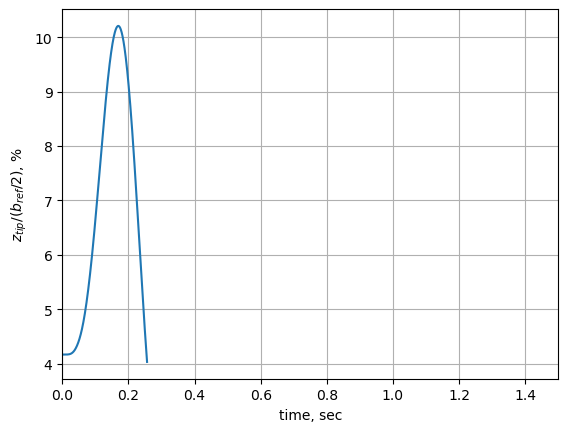

2023-06-20 16:03:21,641 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 16:03:21,642 - sharpy.io.inout_variables - DEBUG - Getting value 0.002422216779199435 for variable pos_node15_index2
2023-06-20 16:03:21,643 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  412  | 0.2575 |  6   |   0.945755   |  11.205537   |  -6.642935   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:03:22,449 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:03:22,450 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:03:22,451 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:03:22,452 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:03:22,453 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:03:22,454 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:03:22,455 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:03:22,456 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:03:22,457 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:03:22,458 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  413  | 0.2581 |  6   |   0.940096   |  11.143522   |  -6.630135   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:03:33,473 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:03:33,475 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:03:33,478 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:03:33,480 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:03:33,482 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:03:33,484 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:03:33,485 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:03:33,486 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:03:33,487 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:03:33,488 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  414  | 0.2587 |  6   |   0.950957   |  12.972380   |  -6.660604   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:03:46,506 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:03:46,507 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:03:46,509 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:03:46,511 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:03:46,512 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:03:46,513 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:03:46,515 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:03:46,516 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:03:46,518 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:03:46,519 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  415  | 0.2594 |  6   |   0.963134   |  15.769125   |  -6.658381   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:04:02,545 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:04:02,547 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:04:02,551 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:04:02,554 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:04:02,558 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:04:02,558 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:04:02,560 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:04:02,560 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:04:02,561 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:04:02,563 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  416  | 0.2600 |  6   |   0.935560   |  10.657249   |  -6.635098   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:04:13,577 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:04:13,579 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:04:13,582 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:04:13,583 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:04:13,584 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:04:13,585 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:04:13,586 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:04:13,586 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:04:13,587 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:04:13,588 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  417  | 0.2606 |  6   |   0.944767   |  10.706418   |  -6.661769   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:04:24,630 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:04:24,632 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:04:24,633 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:04:24,635 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:04:24,637 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:04:24,640 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:04:24,641 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:04:24,643 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:04:24,644 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:04:24,645 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  418  | 0.2612 |  6   |   0.938794   |  11.687306   |  -6.634513   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:04:35,669 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:04:35,672 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:04:35,673 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:04:35,676 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:04:35,678 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:04:35,680 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:04:35,683 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:04:35,685 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:04:35,688 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:04:35,690 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  419  | 0.2619 |  6   |   0.940563   |  12.035899   |  -6.605506   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:04:47,727 - sharpy.io.inout_variables - INFO - Set the input variable control_surface_deflection_idx0 to 0.2067
2023-06-20 16:04:47,729 - sharpy.io.inout_variables - DEBUG - Updated control surface deflection
2023-06-20 16:04:47,732 - sharpy.solvers.dynamiccoupled - DEBUG - Time step 420
2023-06-20 16:04:59,789 - sharpy.solvers.dynamiccoupled - DEBUG - Time loop - about to get out variables from data
2023-06-20 16:04:59,790 - sharpy.io.inout_variables - DEBUG - Getting value 0.0022176648565822433 for variable pos_node15_index2
2023-06-20 16:04:59,791 - sharpy.solvers.dynamiccoupled - INFO - Time Loop - Waiting for input


|  420  | 0.2625 |  6   |   0.937238   |  11.939370   |  -6.601269   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:05:00,759 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:05:00,762 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:05:00,766 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:05:00,768 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:05:00,769 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:05:00,770 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:05:00,771 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:05:00,772 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:05:00,773 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:05:00,774 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  421  | 0.2631 |  6   |   0.940764   |  10.319356   |  -6.607421   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:05:10,789 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:05:10,791 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:05:10,792 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:05:10,793 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:05:10,794 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:05:10,795 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:05:10,797 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:05:10,798 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:05:10,800 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:05:10,801 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  422  | 0.2637 |  6   |   0.939538   |  10.161348   |  -6.634166   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:05:20,815 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:05:20,817 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:05:20,818 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:05:20,820 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:05:20,824 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:05:20,825 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:05:20,829 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:05:20,831 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:05:20,834 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:05:20,836 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  423  | 0.2644 |  6   |   0.943530   |   9.856899   |  -6.618950   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:05:30,855 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:05:30,865 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:05:30,868 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:05:30,871 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:05:30,874 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:05:30,876 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:05:30,878 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:05:30,881 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:05:30,884 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:05:30,887 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  424  | 0.2650 |  6   |   0.922570   |   9.070276   |  -6.654183   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:05:39,905 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:05:39,908 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:05:39,909 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:05:39,911 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:05:39,913 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:05:39,915 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:05:39,916 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:05:39,920 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:05:39,923 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:05:39,925 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  425  | 0.2656 |  6   |   0.946490   |  10.657894   |  -6.732647   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:05:50,945 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:05:50,947 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:05:50,949 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:05:50,950 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:05:50,953 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:05:50,956 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:05:50,958 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:05:50,960 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:05:50,963 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:05:50,965 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  426  | 0.2662 |  5   |   0.948957   |   9.539317   |  -6.000367   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:06:00,981 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:06:00,983 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:06:00,985 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:06:00,986 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:06:00,987 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:06:00,988 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:06:00,988 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:06:00,990 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:06:00,990 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:06:00,991 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  427  | 0.2669 |  6   |   0.941319   |  10.846456   |  -6.727470   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:06:12,005 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:06:12,007 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:06:12,008 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:06:12,010 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:06:12,012 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:06:12,013 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:06:12,014 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:06:12,015 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:06:12,015 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:06:12,016 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  428  | 0.2675 |  5   |   0.930814   |   7.497262   |  -6.019005   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:06:19,026 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:06:19,028 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:06:19,030 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:06:19,031 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:06:19,033 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:06:19,034 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:06:19,038 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:06:19,038 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:06:19,039 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:06:19,040 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  429  | 0.2681 |  5   |   0.936728   |   7.871919   |  -6.030812   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:06:27,050 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:06:27,052 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:06:27,054 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:06:27,055 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:06:27,058 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:06:27,060 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:06:27,063 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:06:27,065 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:06:27,067 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:06:27,069 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  430  | 0.2687 |  5   |   0.937105   |   7.751701   |  -6.054323   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:06:35,084 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:06:35,086 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:06:35,088 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:06:35,090 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:06:35,092 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:06:35,094 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:06:35,097 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:06:35,099 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:06:35,101 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:06:35,103 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  431  | 0.2694 |  5   |   0.932689   |   8.396564   |  -6.089186   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:06:44,118 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:06:44,120 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:06:44,122 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:06:44,124 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:06:44,126 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:06:44,127 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:06:44,128 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:06:44,128 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:06:44,129 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:06:44,130 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  432  | 0.2700 |  5   |   0.939516   |   8.393055   |  -6.135273   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:06:52,141 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:06:52,143 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:06:52,145 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:06:52,147 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:06:52,149 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:06:52,152 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:06:52,153 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:06:52,156 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:06:52,159 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:06:52,160 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  433  | 0.2706 |  5   |   0.942568   |   8.474203   |  -6.131546   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:07:01,175 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:07:01,178 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:07:01,179 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:07:01,181 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:07:01,183 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:07:01,184 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:07:01,185 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:07:01,186 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:07:01,187 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:07:01,188 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  434  | 0.2712 |  5   |   0.943090   |   8.591407   |  -6.131916   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:07:10,205 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:07:10,207 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:07:10,209 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:07:10,212 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:07:10,214 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:07:10,215 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:07:10,215 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:07:10,216 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:07:10,217 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:07:10,217 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  435  | 0.2719 |  5   |   0.945621   |   8.856853   |  -6.166284   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:07:19,252 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:07:19,255 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:07:19,256 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:07:19,259 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:07:19,260 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:07:19,261 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:07:19,262 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:07:19,263 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:07:19,263 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:07:19,264 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  436  | 0.2725 |  5   |   0.941263   |   9.397952   |  -6.133039   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:07:28,277 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:07:28,278 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:07:28,280 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:07:28,282 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:07:28,284 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:07:28,286 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:07:28,288 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:07:28,292 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:07:28,294 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:07:28,295 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  437  | 0.2731 |  5   |   0.945413   |   9.424471   |  -6.158163   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:07:38,313 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:07:38,315 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:07:38,317 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:07:38,320 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:07:38,321 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:07:38,323 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:07:38,324 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:07:38,325 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:07:38,326 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:07:38,326 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

|  438  | 0.2737 |  5   |   0.941385   |   9.580249   |  -6.075470   | 0.000000e+00 | 0.000000e+00 |


2023-06-20 16:07:47,339 - sharpy.io.network_interface - DEBUG - Modifying selector to w
2023-06-20 16:07:47,340 - sharpy.io.network_interface - DEBUG - Out Network ready to receive from the queue
2023-06-20 16:07:47,341 - sharpy.io.network_interface - DEBUG - Out Network - got message from queue
2023-06-20 16:07:47,342 - sharpy.io.inout_variables - DEBUG - Encoding variable pos_node15_index2
2023-06-20 16:07:47,343 - sharpy.io.network_interface - INFO - Message of length 13 bytes ready to send
2023-06-20 16:07:47,344 - sharpy.io.network_interface - DEBUG - Network - Sending
2023-06-20 16:07:47,344 - sharpy.io.network_interface - INFO - Network - Sent data packet to ('127.0.0.1', 59009)
2023-06-20 16:07:47,345 - sharpy.io.network_interface - DEBUG - Modifying selector to r
2023-06-20 16:07:47,346 - sharpy.io.network_interface - INFO - In Network - waiting for input data of size 13 bytes
2023-06-20 16:07:47,347 - sharpy.io.network_interface - INFO - Received a 13-byte long data packet fr

In [150]:
# Load Nonlinear P-Controller Results
nonlinear_tip_displacement_closed_loop = get_resulting_vertical_tip_displacement(output_folder, 
                                                                     pazy_model_closed)


time_array_nonlinear_closed_loop = np.arange(0, len(nonlinear_tip_displacement_closed_loop) * pazy_model_closed.dt, pazy_model_closed.dt)
normalised_tip_displacement_nonlinear_closed_loop = nonlinear_tip_displacement_closed_loop/ (0.5*pazy_model_closed.b_ref) #normalise by half wing span
normalised_tip_displacement_nonlinear_closed_loop *=100# cconvert to percentnvert to percent
plt.plot(time_array_nonlinear_closed_loop, normalised_tip_displacement_nonlinear_closed_loop)
plt.xlabel('time, sec')
plt.ylabel('$z_{tip}/(b_{ref}/2)$, %')
plt.xlim([0., simulation_time])
plt.grid()
plt.show()

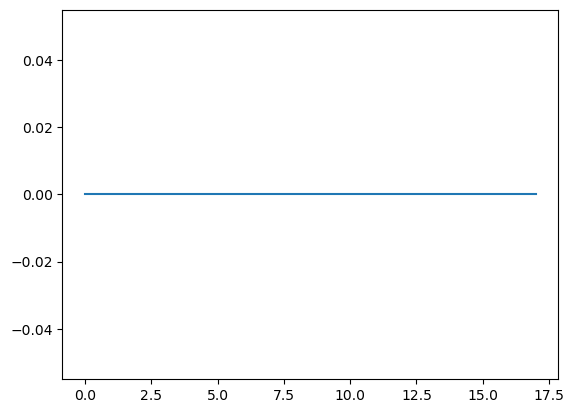

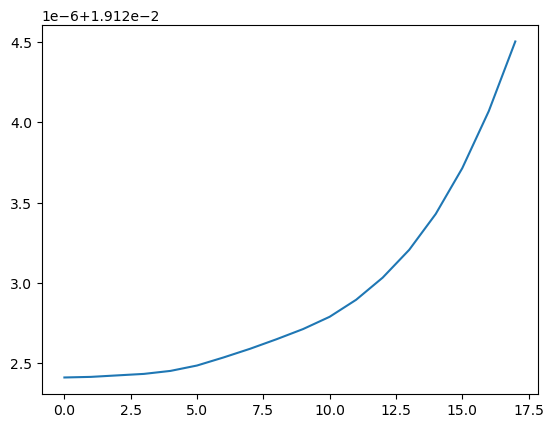

9


In [34]:
control_surface_input = np.loadtxt(os.path.join(output_folder, pazy_model_closed.case_name, "pazy_udp_closed_loop_gust_response_control_input"))
tip_displacement = np.loadtxt(os.path.join(output_folder, pazy_model_closed.case_name, "pazy_udp_closed_loop_gust_response_sensor_measurement"))

plt.plot(control_surface_input)
plt.show()

plt.plot(tip_displacement)
plt.show()
print(pazy_model_closed.num_node_surf)

In [ ]:
# Plot Data
fig, axs = plt.subplots(3, 1)
list_linestyles = ['-', '--', ':']
list_labels = ['linear P=10', 'nonlinear P=10', 'nonlinear open-loop']
axs[0].plot(time_array_linear, normalised_tip_deflection_linear[:,1], list_linestyles[0], label=list_labels[0])
axs[0].plot(time_array_nonlinear_closed_loop, 
            normalised_tip_displacement_nonlinear_closed_loop, 
            list_linestyles[1], 
            label=labels[1])
axs[0].plot(time_array, normalised_tip_displacement, list_linestyles[-1], label=list_labels[-1])

axs[0].legend()
axs[0].set(ylabel='$z_{tip}/(b_{ref}/2)$, %')


axs[1].plot(time_array_linear, control_surface_deflection_deg[:,1], list_linestyles[0])
axs[1].plot(time_array_nonlinear_closed_loop, np.deg2rad(control_surface_input), list_linestyles[1])
    
axs[1].set(ylabel='$\delta$, deg')

axs[2].plot(time_array_linear, control_surface_deflection_rate_deg[:,i], list_linestyles[i])
axs[1].plot(time_array_nonlinear_closed_loop, 
            np.diff(np.deg2rad(control_surface_input))/pazy_model_closed.dt, 
            list_linestyles[1])
    
axs[2].set(ylabel='$\dot{\delta}$, deg/sec')
for ax in axs.flat:
    ax.set(xlabel='time, sec')